**carregar OSATS.CSV**

In [8]:
import os
import pandas as pd
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
# Confirmar onde estamos
print("📂 Diretório atual:", os.getcwd())

# Caminhos relativos corretos
METADADOS_PATH = "../OSS_dataset/Train/OSATS.csv"
print(f"📄 A tentar carregar metadados de: {METADADOS_PATH}")

# Tentar carregar CSV 
try:
    df = pd.read_csv(METADADOS_PATH, sep=';')
    print(f"✅ Metadados carregados com sucesso: {df.shape[0]} linhas, {df.shape[1]} colunas")
    print("🧾 Colunas disponíveis:", list(df.columns))
    print("\n🔍 Primeiras linhas:")
    display(df.head())
except Exception as e:
    print(f"❌ Erro ao carregar CSV com ';': {e}")


📂 Diretório atual: /mounts/grupo3
📄 A tentar carregar metadados de: ../OSS_dataset/Train/OSATS.csv
✅ Metadados carregados com sucesso: 942 linhas, 15 colunas
🧾 Colunas disponíveis: ['STUDENT', 'GROUP', 'TIME', 'SUTURES', 'INVESTIGATOR', 'VIDEO', 'OSATS_RESPECT', 'OSATS_MOTION', 'OSATS_INSTRUMENT', 'OSATS_SUTURE', 'OSATS_FLOW', 'OSATS_KNOWLEDGE', 'OSATS_PERFORMANCE', 'OSATS_FINAL_QUALITY', 'GLOBA_RATING_SCORE']

🔍 Primeiras linhas:


STUDENT       GROUP  TIME SUTURES INVESTIGATOR VIDEO  OSATS_RESPECT  \
0  AHO729  E-LEARNING   PRE       1            A  P54M              2   
1  AHO729  E-LEARNING   PRE       1            B  P54M              2   
2  AHO729  E-LEARNING   PRE       1            C  P54M              2   
3  AHO729  E-LEARNING  POST     4,5            A  M45P              4   
4  AHO729  E-LEARNING  POST     4,5            B  M45P              2   

   OSATS_MOTION  OSATS_INSTRUMENT  OSATS_SUTURE  OSATS_FLOW  OSATS_KNOWLEDGE  \
0             1                 2             2           1                2   
1             1                 3             1           2                1   
2             1                 1             1           1                1   
3             4                 4             3           3                4   
4             3                 4             3           3                4   

   OSATS_PERFORMANCE  OSATS_FINAL_QUALITY  GLOBA_RATING_SCORE  
0                  2                    1                  13  
1                  2                    1                  13  
2                  1                    1                   9  
3                  3                    3                  28  
4                  3                    3                  25

**Verificar videos disponiveis**

In [9]:
VIDEO_DIR = "../OSS_dataset/Train/videos"
print(f"📁 A verificar vídeos no diretório: {VIDEO_DIR}")

try:
    videos = sorted([f for f in os.listdir(VIDEO_DIR) if f.endswith(".mp4")])
    print(f"✅ Foram encontrados {len(videos)} vídeos .mp4")
    print("🎞️ Primeiros 10 vídeos:")
    for v in videos[:10]:
        print(" -", v)
except Exception as e:
    print(f"❌ Erro ao listar vídeos: {e}")


📁 A verificar vídeos no diretório: ../OSS_dataset/Train/videos
✅ Foram encontrados 329 vídeos .mp4
🎞️ Primeiros 10 vídeos:
 - A31H.mp4
 - A36O.mp4
 - A40E.mp4
 - A41X.mp4
 - A59Z.mp4
 - A61V.mp4
 - A66S.mp4
 - A80U.mp4
 - A83X.mp4
 - A88O.mp4


**Função de pré-processamento de frame**

In [10]:
import cv2
import numpy as np

def preprocessar_frame(frame):
    try:
        cinza = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        equalizado = clahe.apply(cinza)
        sem_ruido = cv2.GaussianBlur(equalizado, (5,5), 0)
        h, w = sem_ruido.shape
        roi = sem_ruido[int(h*0.1):int(h*0.9), int(w*0.1):int(w*0.9)]
        redimensionado = cv2.resize(roi, (224, 224))
        return redimensionado
    except Exception as e:
        print(f"❌ Erro ao pré-processar frame: {e}")
        return None

print("✅ Função de pré-processamento carregada.")


✅ Função de pré-processamento carregada.


**Selecionar e listar 20 vídeos aleatórios**

In [4]:
import random

NUM_VIDEOS = 20
random.seed(42)  # para garantir que é reprodutível
selecionados = random.sample(videos, k=NUM_VIDEOS)

print(f"🎬 Selecionados {len(selecionados)} vídeos:")
for v in selecionados:
    print(" -", v)


🎬 Selecionados 20 vídeos:
 - Z95A.mp4
 - F32Q.mp4
 - A99Y.mp4
 - M45P.mp4
 - K88F.mp4
 - K21K.mp4
 - G32E.mp4
 - E66F.mp4
 - W73R.mp4
 - D94Z.mp4
 - Y33I.mp4
 - R77V.mp4
 - B61D.mp4
 - B53D.mp4
 - E23G.mp4
 - K11Q.mp4
 - K53Y.mp4
 - V11G.mp4
 - Y65C.mp4
 - B12G.mp4


**Processar os vídeos (frames + metadados)**

In [22]:
FRAME_DIR = "frames_processados"
os.makedirs(FRAME_DIR, exist_ok=True)

for file in selecionados:
    video_id = file.replace(".mp4", "")
    video_path = os.path.join(VIDEO_DIR, file)
    print(f"\n🔄 {video_id}:")

    try:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise IOError("Não foi possível abrir o vídeo.")

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frames = []

        for i in range(total_frames):
            ret, frame = cap.read()
            if not ret:
                break
            if i % 10 == 0:
                frame_p = preprocessar_frame(frame)
                if frame_p is not None:
                    frames.append(frame_p)

        cap.release()
        print(f"✅ {len(frames)} frames extraídos")

        pasta = os.path.join(FRAME_DIR, video_id)
        os.makedirs(pasta, exist_ok=True)
        np.save(os.path.join(pasta, "frames.npy"), frames)

        linha = df[df["VIDEO"] == video_id]
        if not linha.empty:
            np.save(os.path.join(pasta, "metadados.npy"), linha.iloc[0].to_dict())
            print("📋 Metadados associados")
        else:
            print("⚠️ Metadados não encontrados")

    except Exception as e:
        print(f"❌ Erro ao processar {video_id}: {e}")



🔄 Z95A:
✅ 922 frames extraídos
📋 Metadados associados

🔄 F32Q:
✅ 914 frames extraídos
📋 Metadados associados

🔄 A99Y:
✅ 912 frames extraídos
📋 Metadados associados

🔄 M45P:
✅ 912 frames extraídos
📋 Metadados associados

🔄 K88F:
✅ 920 frames extraídos
📋 Metadados associados

🔄 K21K:
✅ 917 frames extraídos
📋 Metadados associados

🔄 G32E:
✅ 913 frames extraídos
📋 Metadados associados

🔄 E66F:
✅ 912 frames extraídos
📋 Metadados associados

🔄 W73R:
✅ 913 frames extraídos
📋 Metadados associados

🔄 D94Z:
✅ 924 frames extraídos
📋 Metadados associados

🔄 Y33I:
✅ 894 frames extraídos
⚠️ Metadados não encontrados

🔄 R77V:
✅ 911 frames extraídos
📋 Metadados associados

🔄 B61D:
✅ 913 frames extraídos
📋 Metadados associados

🔄 B53D:
✅ 913 frames extraídos
📋 Metadados associados

🔄 E23G:
✅ 915 frames extraídos
📋 Metadados associados

🔄 K11Q:
✅ 907 frames extraídos
📋 Metadados associados

🔄 K53Y:
✅ 907 frames extraídos
📋 Metadados associados

🔄 V11G:
✅ 911 frames extraídos
📋 Metadados associados

🔄 Y

**visualizaçao dos frames**

📁 A36O tem 304 frames processados.


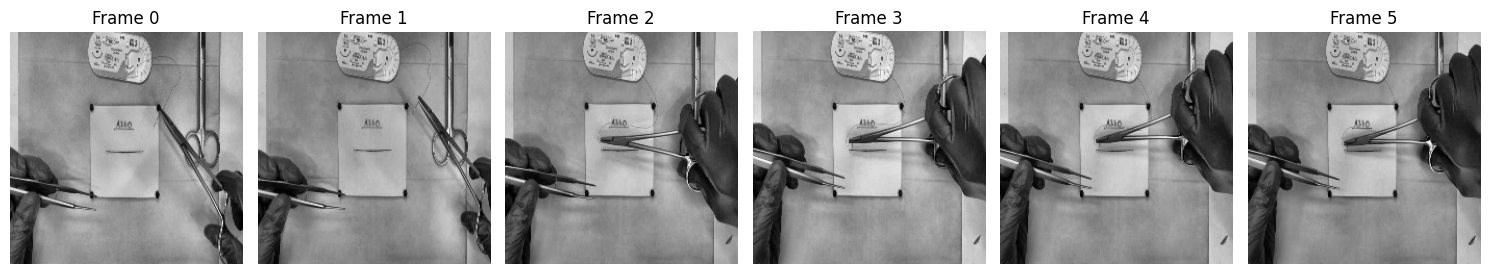

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os 
video_id = "A36O"
path = os.path.join("frames_processados", video_id, "frames.npy")
frames = np.load(path)

print(f"📁 {video_id} tem {len(frames)} frames processados.")

# Mostrar os primeiros 6 frames
plt.figure(figsize=(15, 5))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(frames[i], cmap='gray')
    plt.title(f"Frame {i}")
    plt.axis('off')
plt.tight_layout()
plt.show()


📁 A36O tem 912 frames processados.


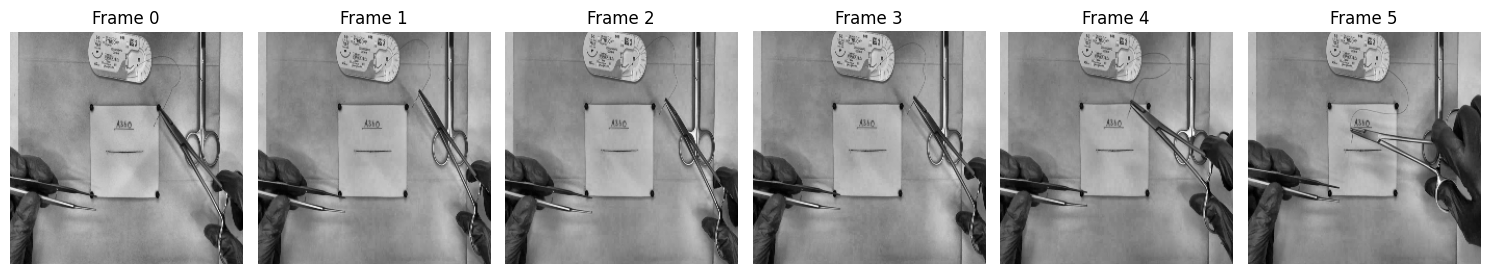

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os 
video_id = "A36O"
path = os.path.join("frames_processados", video_id, "frames.npy")
frames = np.load(path)

print(f"📁 {video_id} tem {len(frames)} frames processados.")

# Mostrar os primeiros 6 frames
plt.figure(figsize=(15, 5))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(frames[i], cmap='gray')
    plt.title(f"Frame {i}")
    plt.axis('off')
plt.tight_layout()
plt.show()


**carregar o dataset**

In [12]:
import numpy as np
import torch

X = []
y = []

print(f"📁 A carregar vídeos da pasta: {FRAME_DIR}")
for video_id in sorted(os.listdir(FRAME_DIR)):
    pasta = os.path.join(FRAME_DIR, video_id)
    
    path_frames = os.path.join(pasta, "frames.npy")
    path_meta = os.path.join(pasta, "metadados.npy")
    
    if not os.path.exists(path_frames) or not os.path.exists(path_meta):
        print(f"⚠️ A ignorar {video_id} (falta frames ou metadados)")
        continue

    try:
        frames = np.load(path_frames).astype("float32") / 255.0  # Normalizar
        frames = np.expand_dims(frames, axis=1)  # (n_frames, 1, 224, 224)

        meta = np.load(path_meta, allow_pickle=True).item()
        grs = meta.get("GLOBA_RATING_SCORE", None)

        if grs is None:
            print(f"⚠️ {video_id} sem GLOBA_RATING_SCORE")
            continue

        if grs <= 15:
            classe = 0
        elif grs <= 23:
            classe = 1
        elif grs <= 31:
            classe = 2
        else:
            classe = 3

        X.append(torch.tensor(frames, dtype=torch.float32))
        y.append(classe)

        print(f"✅ {video_id}: {frames.shape[0]} frames, classe {classe}")

    except Exception as e:
        print(f"❌ Erro ao carregar {video_id}: {e}")


📁 A carregar vídeos da pasta: frames_processados
✅ A36O: 912 frames, classe 0
✅ A83X: 910 frames, classe 2
✅ A99X: 910 frames, classe 3
✅ A99Y: 912 frames, classe 0
✅ B12G: 912 frames, classe 0
✅ B53D: 913 frames, classe 0
✅ B61D: 913 frames, classe 0
✅ C58C: 925 frames, classe 3
✅ D94Z: 924 frames, classe 0
✅ E23G: 915 frames, classe 2
✅ E45Q: 910 frames, classe 1
✅ E66F: 912 frames, classe 2
✅ F03Z: 912 frames, classe 2
✅ F32Q: 914 frames, classe 0
✅ F66N: 914 frames, classe 2
✅ F88K: 910 frames, classe 3
✅ G21B: 916 frames, classe 1
✅ G32E: 913 frames, classe 0
✅ G61C: 918 frames, classe 2
✅ H27O: 910 frames, classe 0
✅ H87Y: 910 frames, classe 3
✅ I23K: 912 frames, classe 1
✅ I33C: 918 frames, classe 3
✅ J88T: 913 frames, classe 2
✅ K11Q: 907 frames, classe 0
✅ K21K: 917 frames, classe 0
✅ K43V: 914 frames, classe 1
✅ K53Y: 907 frames, classe 0
✅ K78J: 911 frames, classe 0
✅ K88F: 920 frames, classe 0
✅ L29G: 913 frames, classe 0
✅ M45P: 912 frames, classe 2
✅ P63X: 916 frames, cla

**Padding, Divisão e DataLoaders para Treino**

In [13]:
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

# Padding até MAX_FRAMES
print("📏 A aplicar padding aos vídeos...")
MAX_FRAMES = 120

X_padded = pad_sequence(X, batch_first=True)  # (n_videos, n_frames, 1, 224, 224)

if X_padded.size(1) > MAX_FRAMES:
    X_padded = X_padded[:, :MAX_FRAMES]
else:
    pad_len = MAX_FRAMES - X_padded.size(1)
    X_padded = torch.nn.functional.pad(X_padded, (0, 0, 0, 0, 0, 0, 0, pad_len))

y_tensor = torch.tensor(y, dtype=torch.long)

# Divisão treino/teste
print("🔀 A dividir treino/teste...")
X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y_tensor, test_size=0.2, random_state=42
)

# Dataset personalizado
class SuturaDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# DataLoaders
BATCH_SIZE = 2
train_loader = DataLoader(SuturaDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(SuturaDataset(X_test, y_test), batch_size=BATCH_SIZE)

print(f"✅ Dados prontos: {len(X_train)} treino | {len(X_test)} teste")


📏 A aplicar padding aos vídeos...
🔀 A dividir treino/teste...
✅ Dados prontos: 37 treino | 10 teste


**Modelo CNN 3D + Treino e Avaliação**


🚀 Início do treino...
📚 Época 1: Loss=11.6651 | Accuracy=0.00
📚 Época 2: Loss=11.3223 | Accuracy=0.00
📚 Época 3: Loss=11.0239 | Accuracy=0.00
📚 Época 4: Loss=10.6976 | Accuracy=0.27
📚 Época 5: Loss=10.3708 | Accuracy=0.67
📚 Época 6: Loss=10.0669 | Accuracy=0.67
📚 Época 7: Loss=9.7282 | Accuracy=0.67
📚 Época 8: Loss=9.3988 | Accuracy=0.67
📚 Época 9: Loss=9.1119 | Accuracy=0.67
📚 Época 10: Loss=8.7738 | Accuracy=0.67

📊 Relatório de desempenho:
📌 Classes no teste: [0, 2] → ['Novato', 'Proficiente']
              precision    recall  f1-score   support

      Novato       0.75      1.00      0.86         3
 Proficiente       0.00      0.00      0.00         1

    accuracy                           0.75         4
   macro avg       0.38      0.50      0.43         4
weighted avg       0.56      0.75      0.64         4



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/IPython/c

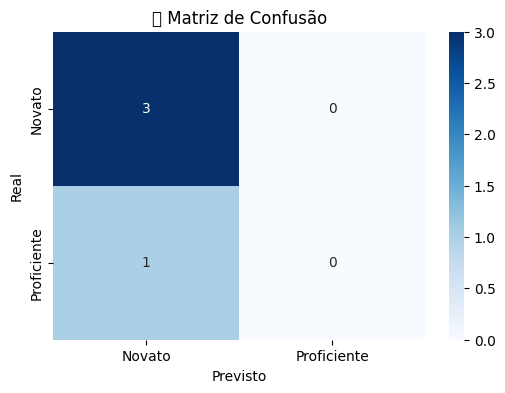

In [17]:
import torch.nn as nn
import torch.optim as optim

# ✅ Definir modelo CNN 3D simples
class CNN3D(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv3d(in_channels=1, out_channels=8, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveAvgPool3d((1, 1, 1))  # Reduz para (8, 1, 1, 1)
        self.fc = nn.Linear(8, 4)  # 4 classes

    def forward(self, x):
        x = self.conv(x)      # (B, 8, D, H, W)
        x = self.relu(x)
        x = self.pool(x)      # (B, 8, 1, 1, 1)
        x = x.view(x.size(0), -1)  # (B, 8)
        x = self.fc(x)        # (B, 4)
        return x

# ✅ Instanciar modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN3D().to(device)

# ✅ Otimizador e função de custo
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# ✅ Treinar
EPOCHS = 10
print("🚀 Início do treino...")
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)  # Corrigir shape para (B, C, D, H, W)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"📚 Época {epoch+1}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")

# ✅ Avaliação
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)  # Corrigir shape para (B, C, D, H, W)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_true.extend(labels.numpy())
        y_pred.extend(preds)

# ✅ Relatório de desempenho (com classes dinâmicas)
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

print("\n📊 Relatório de desempenho:")

# Detetar classes reais e ajustar nomes
labels_presentes = sorted(unique_labels(y_true, y_pred))
nomes = ["Novato", "Intermédio", "Proficiente", "Especialista"]
nomes_presentes = [nomes[i] for i in labels_presentes]

print(f"📌 Classes no teste: {labels_presentes} → {nomes_presentes}")
print(classification_report(y_true, y_pred, labels=labels_presentes, target_names=nomes_presentes))

# ✅ Matriz de confusão
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=nomes_presentes, yticklabels=nomes_presentes)
plt.title("📌 Matriz de Confusão")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()


**Selecionar vídeos equilibrados diretamente do CSV**

In [14]:
import os

# Recalcular a classe com base no GLOBA_RATING_SCORE
df["classe"] = df["GLOBA_RATING_SCORE"].apply(
    lambda g: 0 if g <= 15 else 1 if g <= 23 else 2 if g <= 31 else 3
)

# Ver vídeos que existem realmente na pasta /videos
VIDEO_DIR = "../OSS_dataset/Train/videos"
videos_existentes = set(f.replace(".mp4", "") for f in os.listdir(VIDEO_DIR) if f.endswith(".mp4"))

# Filtrar linhas do CSV que têm vídeo disponível
df_validos = df[df["VIDEO"].isin(videos_existentes)]

# Garantir que não há duplicados por vídeo (caso o mesmo vídeo esteja avaliado várias vezes)
df_unicos = df_validos.drop_duplicates(subset="VIDEO")

# Verificar distribuição disponível
distribuicao = df_unicos["classe"].value_counts().sort_index()
nomes = ["Novato", "Intermédio", "Proficiente", "Especialista"]

print("📊 Distribuição de vídeos com ficheiros existentes:")
for i in range(4):
    print(f" - {nomes[i]} ({i}): {distribuicao.get(i, 0)} vídeos")

# Selecionar 5 para treino + 2 para teste de cada classe
treino, teste = [], []

for classe in range(4):
    videos_classe = df_unicos[df_unicos["classe"] == classe].sample(
        n=7, random_state=42, replace=False if distribuicao.get(classe, 0) >= 7 else True
    )
    treino += list(videos_classe.iloc[:5]["VIDEO"])
    teste += list(videos_classe.iloc[5:7]["VIDEO"])

print("\n🎯 Seleção concluída:")
print(f" - {len(treino)} vídeos para treino")
print(f" - {len(teste)} vídeos para teste")


📊 Distribuição de vídeos com ficheiros existentes:
 - Novato (0): 122 vídeos
 - Intermédio (1): 57 vídeos
 - Proficiente (2): 110 vídeos
 - Especialista (3): 25 vídeos

🎯 Seleção concluída:
 - 20 vídeos para treino
 - 8 vídeos para teste


**processar apenas vídeos selecionados**

In [15]:
import cv2
import numpy as np

FRAME_DIR = "frames_processados"
os.makedirs(FRAME_DIR, exist_ok=True)

def preprocessar_frame(frame):
    cinza = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    equalizado = clahe.apply(cinza)
    sem_ruido = cv2.GaussianBlur(equalizado, (5,5), 0)
    h, w = sem_ruido.shape
    roi = sem_ruido[int(h*0.1):int(h*0.9), int(w*0.1):int(w*0.9)]
    redimensionado = cv2.resize(roi, (224, 224))
    return redimensionado

def extrair_frames(video_path, intervalo=30):
    cap = cv2.VideoCapture(video_path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames = []

    for i in range(total):
        ret, frame = cap.read()
        if not ret:
            break
        if i % intervalo == 0:
            f = preprocessar_frame(frame)
            if f is not None:
                frames.append(f)

    cap.release()
    return np.array(frames)

print("⚙️ A processar vídeos selecionados...")

for video_id in treino + teste:
    path_mp4 = os.path.join(VIDEO_DIR, f"{video_id}.mp4")
    pasta_destino = os.path.join(FRAME_DIR, video_id)

    if not os.path.exists(path_mp4):
        print(f"⚠️ Vídeo não encontrado: {video_id}")
        continue

    os.makedirs(pasta_destino, exist_ok=True)

    try:
        print(f"🔄 {video_id}...")
        frames = extrair_frames(path_mp4)
        np.save(os.path.join(pasta_destino, "frames.npy"), frames)

        linha = df[df["VIDEO"] == video_id].iloc[0].to_dict()
        np.save(os.path.join(pasta_destino, "metadados.npy"), linha)
        print(f"✅ {len(frames)} frames guardados | Metadados associados")
    except Exception as e:
        print(f"❌ Erro no vídeo {video_id}: {e}")


⚙️ A processar vídeos selecionados...
🔄 K78J...
✅ 304 frames guardados | Metadados associados
🔄 A36O...
✅ 304 frames guardados | Metadados associados
🔄 H27O...
✅ 304 frames guardados | Metadados associados
🔄 P94X...
✅ 304 frames guardados | Metadados associados
🔄 V16A...
✅ 305 frames guardados | Metadados associados
🔄 K43V...
✅ 305 frames guardados | Metadados associados
🔄 V15D...
✅ 305 frames guardados | Metadados associados
🔄 T34C...
✅ 303 frames guardados | Metadados associados
🔄 E45Q...
✅ 304 frames guardados | Metadados associados
🔄 Q17K...
✅ 306 frames guardados | Metadados associados
🔄 A83X...
✅ 304 frames guardados | Metadados associados
🔄 F66N...
✅ 305 frames guardados | Metadados associados
🔄 G61C...
✅ 306 frames guardados | Metadados associados
🔄 J88T...
✅ 305 frames guardados | Metadados associados
🔄 P63X...
✅ 306 frames guardados | Metadados associados
🔄 I33C...
✅ 306 frames guardados | Metadados associados
🔄 X49P...
✅ 304 frames guardados | Metadados associados
🔄 Q83Q...


In [100]:
import torch.nn as nn

def get_model(nome):
    if nome == "CNN3D_Simples":
        class M(nn.Module):
            def __init__(self):
                super().__init__()
                self.rede = nn.Sequential(
                    nn.Conv3d(1, 8, 3, padding=1),
                    nn.ReLU(),
                    nn.AdaptiveAvgPool3d((1, 1, 1)),
                    nn.Flatten(),
                    nn.Linear(8, 4)
                )
            def forward(self, x): return self.rede(x)
        return M()

    elif nome == "CNN3D_Profunda":
        class M(nn.Module):
            def __init__(self):
                super().__init__()
                self.rede = nn.Sequential(
                    nn.Conv3d(1, 16, 3, padding=1),
                    nn.ReLU(),
                    nn.Conv3d(16, 32, 3, padding=1),
                    nn.ReLU(),
                    nn.AdaptiveAvgPool3d((1, 1, 1)),
                    nn.Flatten(),
                    nn.Linear(32, 4)
                )
            def forward(self, x): return self.rede(x)
        return M()

    elif nome == "CNN3D_Dropout":
        class M(nn.Module):
            def __init__(self):
                super().__init__()
                self.rede = nn.Sequential(
                    nn.Conv3d(1, 16, 3, padding=1),
                    nn.ReLU(),
                    nn.MaxPool3d(2),
                    nn.Conv3d(16, 32, 3, padding=1),
                    nn.ReLU(),
                    nn.AdaptiveAvgPool3d((1, 1, 1)),
                    nn.Flatten(),
                    nn.Dropout(0.5),
                    nn.Linear(32, 4)
                )
            def forward(self, x): return self.rede(x)
        return M()

    elif nome == "CNN3D_BatchNorm":
        class M(nn.Module):
            def __init__(self):
                super().__init__()
                self.rede = nn.Sequential(
                    nn.Conv3d(1, 16, 3, padding=1),
                    nn.BatchNorm3d(16),
                    nn.ReLU(),
                    nn.Conv3d(16, 32, 3, padding=1),
                    nn.BatchNorm3d(32),
                    nn.ReLU(),
                    nn.AdaptiveAvgPool3d((1, 1, 1)),
                    nn.Flatten(),
                    nn.Linear(32, 4)
                )
            def forward(self, x): return self.rede(x)
        return M()

    elif nome == "CNN3D_Minimal":
        class M(nn.Module):
            def __init__(self):
                super().__init__()
                self.conv = nn.Conv3d(1, 4, 3, padding=1)
                self.pool = nn.AdaptiveAvgPool3d((1, 1, 1))
                self.fc = nn.Linear(4, 4)
            def forward(self, x):
                x = self.pool(nn.ReLU()(self.conv(x)))
                x = x.view(x.size(0), -1)
                return self.fc(x)
        return M()

    else:
        raise ValueError("❌ Modelo desconhecido: " + nome)


**dos modelos acima so o BATCHNORM é que conseguiu prever diferentes classes**

**Decidimos mudar abordagem conforme o numero de entradas de cada classe no dataset todo**

In [30]:
import os
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

# Caminho para o CSV 
csv_path = "../OSS_dataset/Train/OSATS.csv"
df = pd.read_csv(csv_path, sep=";")

# Definir as classes GRS ( Task 1)
df["classe"] = df["GLOBA_RATING_SCORE"].apply(
    lambda g: 0 if g <= 15 else 1 if g <= 23 else 2 if g <= 31 else 3
)

# Ver distribuição total
print("📊 Distribuição global no dataset:")
distrib_total = df["classe"].value_counts().sort_index()
nomes = ["Novato", "Intermédio", "Proficiente", "Especialista"]
for i in range(4):
    print(f" - {nomes[i]} ({i}): {distrib_total.get(i, 0)} vídeos")

# ➕ Ver percentagens para basear a amostra de 250 vídeos
proporcao = distrib_total / distrib_total.sum()
proporcao_250 = (proporcao * 250).round().astype(int)
print("\n🎯 Número alvo por classe para amostra de 250 vídeos (distribuição real):")
for i in range(4):
    print(f" - {nomes[i]} ({i}): {proporcao_250.get(i, 0)} vídeos")

# 📁 Ver vídeos que já estão processados (com frames e metadados)
FRAME_DIR = "frames_processados"
videos_processados = [
    v for v in os.listdir(FRAME_DIR)
    if os.path.exists(os.path.join(FRAME_DIR, v, "frames.npy"))
    and os.path.exists(os.path.join(FRAME_DIR, v, "metadados.npy"))
]

# Obter classes dos vídeos já processados
classes_processadas = []
for v in videos_processados:
    path_meta = os.path.join(FRAME_DIR, v, "metadados.npy")
    try:
        meta = np.load(path_meta, allow_pickle=True).item()
        grs = meta.get("GLOBA_RATING_SCORE", None)
        if grs is not None:
            if grs <= 15:
                classes_processadas.append(0)
            elif grs <= 23:
                classes_processadas.append(1)
            elif grs <= 31:
                classes_processadas.append(2)
            else:
                classes_processadas.append(3)
    except:
        pass

# Contar por classe
cont_proc = Counter(classes_processadas)
print("\n📦 Já tens processados:")
for i in range(4):
    print(f" - {nomes[i]} ({i}): {cont_proc.get(i, 0)} vídeos")

# 🧮 Quantos ainda faltam processar por classe
faltam = {i: max(0, proporcao_250[i] - cont_proc.get(i, 0)) for i in range(4)}
print("\n🧩 Faltam processar:")
for i in range(4):
    print(f" - {nomes[i]} ({i}): {faltam[i]} vídeos")

# ✅ Selecionar os vídeos a processar
# Ignorar os que já estão processados
videos_csv = df.drop_duplicates(subset="VIDEO")
videos_csv = videos_csv[videos_csv["VIDEO"].isin(set(videos_csv["VIDEO"]) - set(videos_processados))]

# Selecionar faltas por classe
selecionar = []
for classe in range(4):
    subset = videos_csv[videos_csv["classe"] == classe]
    n_disponiveis = len(subset)
    n_desejado = faltam[classe]
    n_uso = min(n_desejado, n_disponiveis)  # class CNN3D_BatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d(2),
            nn.Conv3d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((1, 1, 1)),
            nn.Flatten(),
            nn.Linear(32, 4)
        )

    def forward(self, x):
        return self.net(x)
não exceder disponíveis

    if n_uso > 0:
        amostra = subset.sample(n=n_uso, random_state=42)
        selecionar.extend(amostra["VIDEO"].tolist())

print(f"\n🎥 Total a processar agora: {len(selecionar)} vídeos")

📊 Distribuição global no dataset:
 - Novato (0): 324 vídeos
 - Intermédio (1): 248 vídeos
 - Proficiente (2): 267 vídeos
 - Especialista (3): 103 vídeos

🎯 Número alvo por classe para amostra de 250 vídeos (distribuição real):
 - Novato (0): 86 vídeos
 - Intermédio (1): 66 vídeos
 - Proficiente (2): 71 vídeos
 - Especialista (3): 27 vídeos

📦 Já tens processados:
 - Novato (0): 20 vídeos
 - Intermédio (1): 8 vídeos
 - Proficiente (2): 12 vídeos
 - Especialista (3): 7 vídeos

🧩 Faltam processar:
 - Novato (0): 66 vídeos
 - Intermédio (1): 58 vídeos
 - Proficiente (2): 59 vídeos
 - Especialista (3): 20 vídeos

🎥 Total a processar agora: 192 vídeos


In [31]:
import os
import cv2
import numpy as np

# Caminhos
VIDEO_DIR = "../OSS_dataset/Train/videos"
FRAME_DIR = "frames_processados"
os.makedirs(FRAME_DIR, exist_ok=True)

# Função de pré-processamento
def preprocessar_frame(frame):
    cinza = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    equalizado = clahe.apply(cinza)
    sem_ruido = cv2.GaussianBlur(equalizado, (5,5), 0)
    h, w = sem_ruido.shape
    roi = sem_ruido[int(h*0.1):int(h*0.9), int(w*0.1):int(w*0.9)]
    redimensionado = cv2.resize(roi, (224, 224))
    return redimensionado

# Função para extrair frames
def extrair_frames(video_path, intervalo=30):
    cap = cv2.VideoCapture(video_path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames = []

    for i in range(total):
        ret, frame = cap.read()
        if not ret:
            break
        if i % intervalo == 0:
            f = preprocessar_frame(frame)
            if f is not None:
                frames.append(f)

    cap.release()
    return np.array(frames)

# ⚙️ Processar vídeos
print("⚙️ A processar vídeos faltantes...")

for video_id in selecionar:
    path_mp4 = os.path.join(VIDEO_DIR, f"{video_id}.mp4")
    pasta_destino = os.path.join(FRAME_DIR, video_id)

    # Ignorar se já processado
    if os.path.exists(os.path.join(pasta_destino, "frames.npy")):
        print(f"⏭️ {video_id} já processado — ignorado.")
        continue

    if not os.path.exists(path_mp4):
        print(f"⚠️ Vídeo não encontrado: {video_id}")
        continue

    os.makedirs(pasta_destino, exist_ok=True)

    try:
        print(f"🔄 {video_id}...")
        frames = extrair_frames(path_mp4, intervalo=30)
        np.save(os.path.join(pasta_destino, "frames.npy"), frames)

        linha = df[df["VIDEO"] == video_id].iloc[0].to_dict()
        np.save(os.path.join(pasta_destino, "metadados.npy"), linha)

        print(f"✅ {len(frames)} frames guardados | Metadados associados")

    except Exception as e:
        print(f"❌ Erro no vídeo {video_id}: {e}")


⚙️ A processar vídeos faltantes...
🔄 C65K...
✅ 304 frames guardados | Metadados associados
🔄 P11H...
✅ 305 frames guardados | Metadados associados
🔄 S33L...
✅ 306 frames guardados | Metadados associados
🔄 W67S...
✅ 303 frames guardados | Metadados associados
🔄 C42I...
✅ 302 frames guardados | Metadados associados
🔄 I45Y...
✅ 305 frames guardados | Metadados associados
🔄 A80U...
✅ 306 frames guardados | Metadados associados
🔄 E47O...
✅ 305 frames guardados | Metadados associados
🔄 K16O...
✅ 305 frames guardados | Metadados associados
🔄 P54M...
✅ 305 frames guardados | Metadados associados
🔄 L84T...
✅ 311 frames guardados | Metadados associados
🔄 C36X...
✅ 304 frames guardados | Metadados associados
🔄 X36T...
✅ 304 frames guardados | Metadados associados
🔄 R37W...
✅ 305 frames guardados | Metadados associados
🔄 P20V...
✅ 304 frames guardados | Metadados associados
🔄 S84F...
✅ 304 frames guardados | Metadados associados
🔄 F66E...
✅ 305 frames guardados | Metadados associados
🔄 I70X...
✅ 3

In [34]:
import os
import numpy as np
from collections import Counter

FRAME_DIR = "frames_processados"

# Verifica se a pasta existe
if not os.path.exists(FRAME_DIR):
    print(f"❌ A pasta '{FRAME_DIR}' não foi encontrada.")
else:
    videos = sorted(os.listdir(FRAME_DIR))
    print(f"📦 Total de vídeos processados: {len(videos)}")

    classes = []
    erros = []

    for video_id in videos:
        path_meta = os.path.join(FRAME_DIR, video_id, "metadados.npy")
        if not os.path.exists(path_meta):
            erros.append(video_id)
            continue

        meta = np.load(path_meta, allow_pickle=True).item()
        grs = meta.get("GLOBA_RATING_SCORE", None)
        if grs is None:
            erros.append(video_id)
            continue

        # Determinar classe GRS
        if grs <= 15:
            classe = 0  # Novato
        elif grs <= 23:
            classe = 1  # Intermédio
        elif grs <= 31:
            classe = 2  # Proficiente
        else:
            classe = 3  # Especialista

        classes.append(classe)

    # Mostrar distribuição
    nomes = ["Novato", "Intermédio", "Proficiente", "Especialista"]
    contagem = Counter(classes)

    print("\n📊 Distribuição por classe GRS dos vídeos processados:")
    for i in range(4):
        print(f" - {nomes[i]} ({i}): {contagem.get(i, 0)} vídeos")

    if erros:
        print(f"\n⚠️ {len(erros)} vídeos com erro ou sem metadados:")
        for e in erros:
            print(f" - {e}")


📦 Total de vídeos processados: 240

📊 Distribuição por classe GRS dos vídeos processados:
 - Novato (0): 86 vídeos
 - Intermédio (1): 57 vídeos
 - Proficiente (2): 71 vídeos
 - Especialista (3): 25 vídeos

⚠️ 1 vídeos com erro ou sem metadados:
 - Y33I


In [35]:
import os
import cv2
import numpy as np
import pandas as pd

# Diretórios
VIDEO_DIR = "../OSS_dataset/Train/videos"
FRAME_DIR = "frames_processados"
os.makedirs(FRAME_DIR, exist_ok=True)

# Carregar metadados
df = pd.read_csv("../OSS_dataset/Train/OSATS.csv", sep=";")
df["classe"] = df["GLOBA_RATING_SCORE"].apply(
    lambda g: 0 if g <= 15 else 1 if g <= 23 else 2 if g <= 31 else 3
)

# Ver vídeos já processados
videos_processados = set(os.listdir(FRAME_DIR))
videos_validos = set(f.replace(".mp4", "") for f in os.listdir(VIDEO_DIR) if f.endswith(".mp4"))

# ✅ Quantos vídeos faltam por classe
alvo = {1: 66, 3: 27}  # só faltam destas classes
atual = {1: 57, 3: 25}
faltam = {classe: alvo[classe] - atual[classe] for classe in alvo}

# Selecionar vídeos ainda não processados
selecionar = []

for classe in faltam:
    n_faltam = faltam[classe]
    candidatos = df[(df["classe"] == classe) & (df["VIDEO"].isin(videos_validos - videos_processados))]
    amostra = candidatos.sample(n=n_faltam, random_state=42) if n_faltam <= len(candidatos) else candidatos
    selecionar.extend(amostra["VIDEO"].tolist())

print(f"\n📦 Total a processar agora: {len(selecionar)} vídeos → {faltam}")

# -------------------------------------------------------------
# Função de pré-processamento
def preprocessar_frame(frame):
    cinza = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    equalizado = clahe.apply(cinza)
    sem_ruido = cv2.GaussianBlur(equalizado, (5,5), 0)
    h, w = sem_ruido.shape
    roi = sem_ruido[int(h*0.1):int(h*0.9), int(w*0.1):int(w*0.9)]
    redimensionado = cv2.resize(roi, (224, 224))
    return redimensionado

# Função para extrair frames
def extrair_frames(video_path, intervalo=30):
    cap = cv2.VideoCapture(video_path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames = []

    for i in range(total):
        ret, frame = cap.read()
        if not ret:
            break
        if i % intervalo == 0:
            f = preprocessar_frame(frame)
            if f is not None:
                frames.append(f)

    cap.release()
    return np.array(frames)

# ⚙️ Processar os vídeos necessários
print("\n⚙️ A processar vídeos faltantes...")
for video_id in selecionar:
    path_mp4 = os.path.join(VIDEO_DIR, f"{video_id}.mp4")
    pasta_destino = os.path.join(FRAME_DIR, video_id)

    if os.path.exists(os.path.join(pasta_destino, "frames.npy")):
        print(f"⏭️ {video_id} já processado — ignorado.")
        continue

    if not os.path.exists(path_mp4):
        print(f"⚠️ Vídeo não encontrado: {video_id}")
        continue

    os.makedirs(pasta_destino, exist_ok=True)

    try:
        print(f"🔄 {video_id}...")
        frames = extrair_frames(path_mp4, intervalo=30)
        np.save(os.path.join(pasta_destino, "frames.npy"), frames)

        linha = df[df["VIDEO"] == video_id].iloc[0].to_dict()
        np.save(os.path.join(pasta_destino, "metadados.npy"), linha)

        print(f"✅ {len(frames)} frames guardados | Metadados associados")
    except Exception as e:
        print(f"❌ Erro no vídeo {video_id}: {e}")



📦 Total a processar agora: 11 vídeos → {1: 9, 3: 2}

⚙️ A processar vídeos faltantes...
🔄 A92O...
✅ 305 frames guardados | Metadados associados
🔄 C18X...
✅ 304 frames guardados | Metadados associados
🔄 A40E...
✅ 305 frames guardados | Metadados associados
🔄 X61S...
✅ 304 frames guardados | Metadados associados
🔄 H33Z...
✅ 302 frames guardados | Metadados associados
🔄 T90M...
✅ 305 frames guardados | Metadados associados
🔄 O77S...
✅ 305 frames guardados | Metadados associados
🔄 Q23F...
✅ 304 frames guardados | Metadados associados
🔄 F95D...
✅ 305 frames guardados | Metadados associados
🔄 A41X...
✅ 305 frames guardados | Metadados associados
🔄 Z93E...
✅ 305 frames guardados | Metadados associados


In [95]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter

# Caminho dos dados processados
FRAME_DIR = "frames_processados"

# Lê os vídeos que têm metadados
videos_completos = []
labels = []

for video_id in sorted(os.listdir(FRAME_DIR)):
    path_meta = os.path.join(FRAME_DIR, video_id, "metadados.npy")
    if os.path.exists(path_meta):
        meta = np.load(path_meta, allow_pickle=True).item()
        grs = meta.get("GLOBA_RATING_SCORE")
        if grs is not None:
            if grs <= 15:
                classe = 0
            elif grs <= 23:
                classe = 1
            elif grs <= 31:
                classe = 2
            else:
                classe = 3
            videos_completos.append(video_id)
            labels.append(classe)

print(f"✅ Vídeos com metadados válidos: {len(videos_completos)}")

# Dividir mantendo proporção de classes
treino, teste, y_train, y_test = train_test_split(
    videos_completos, labels, test_size=0.2, stratify=labels, random_state=42
)

# Mostrar distribuição por classe
def contar_classes(nome, y):
    c = Counter(y)
    print(f"\n📊 Distribuição no {nome}:")
    for i, label in enumerate(["Novato", "Intermédio", "Proficiente", "Especialista"]):
        print(f" - {label} ({i}): {c.get(i, 0)} vídeos")

contar_classes("conjunto de treino", y_train)
contar_classes("conjunto de teste", y_test)

print(f"\n✅ Total: {len(treino)} treino + {len(teste)} teste = {len(treino) + len(teste)} vídeos")

# Guardar as listas (opcional)
np.save("videos_treino.npy", treino)
np.save("videos_teste.npy", teste)


✅ Vídeos com metadados válidos: 250

📊 Distribuição no conjunto de treino:
 - Novato (0): 73 vídeos
 - Intermédio (1): 45 vídeos
 - Proficiente (2): 62 vídeos
 - Especialista (3): 20 vídeos

📊 Distribuição no conjunto de teste:
 - Novato (0): 18 vídeos
 - Intermédio (1): 12 vídeos
 - Proficiente (2): 15 vídeos
 - Especialista (3): 5 vídeos

✅ Total: 200 treino + 50 teste = 250 vídeos


In [132]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
import os

MAX_FRAMES = 100
BATCH_SIZE = 1

# Dataset personalizado
class SuturaDataset(Dataset):
    def __init__(self, lista_videos):
        self.videos = lista_videos

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        video_id = self.videos[idx]
        pasta = os.path.join("frames_processados", video_id)

        frames = np.load(os.path.join(pasta, "frames.npy"))
        meta = np.load(os.path.join(pasta, "metadados.npy"), allow_pickle=True).item()

        # Normalização e canal único
        frames = frames.astype("float32") / 255.0
        frames = np.expand_dims(frames, axis=1)  # (n_frames, 1, 224, 224)

        # Truncar ou completar para MAX_FRAMES (uniformemente ao longo do vídeo)
        if frames.shape[0] > MAX_FRAMES:
            indices = np.linspace(0, frames.shape[0] - 1, MAX_FRAMES).astype(int)
            frames = frames[indices]
        elif frames.shape[0] < MAX_FRAMES:
            pad = np.zeros((MAX_FRAMES - frames.shape[0], 1, 224, 224), dtype=np.float32)
            frames = np.concatenate([frames, pad], axis=0)


        # Classe GRS
        grs = meta["GLOBA_RATING_SCORE"]
        if grs <= 15:
            label = 0
        elif grs <= 23:
            label = 1
        elif grs <= 31:
            label = 2
        else:
            label = 3

        return torch.tensor(frames), torch.tensor(label)

# Criar datasets
ds_train = SuturaDataset(treino)
ds_test = SuturaDataset(teste)

# Criar DataLoaders
train_loader = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(ds_test, batch_size=BATCH_SIZE)

print(f"✅ Loaders criados: {len(ds_train)} treino | {len(ds_test)} teste")


✅ Loaders criados: 200 treino | 50 teste


In [141]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Define o modelo aqui
model_name = "CNN3D_Light"
model = get_model(model_name).to("cuda" if torch.cuda.is_available() else "cpu")

device = next(model.parameters()).device
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# ✅ Treino
EPOCHS = 10
print(f"🚀 Início do treino com {model_name}...")

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)  # (B, C, D, H, W)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = correct / total if total > 0 else 0
    print(f"📚 Época {epoch+1}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")

# ✅ Avaliação
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_true.extend(labels.numpy())
        y_pred.extend(preds)

# ✅ Relatório de desempenho
print("\n📊 Relatório de desempenho:")

labels_presentes = sorted(unique_labels(y_true + y_pred))
nomes = ["Novato", "Intermédio", "Proficiente", "Especialista"]
nomes_presentes = [nomes[i] for i in labels_presentes]

print(f"📌 Classes no teste: {labels_presentes} → {nomes_presentes}")
print(classification_report(y_true, y_pred, labels=labels_presentes, target_names=nomes_presentes, zero_division=0))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=nomes_presentes, yticklabels=nomes_presentes)
plt.title(f"📌 Matriz de Confusão - {model_name}")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


🚀 Início do treino com CNN3D_Light...


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 47.41 GiB of which 2.69 MiB is free. Process 550717 has 8.78 GiB memory in use. Process 1100869 has 20.31 GiB memory in use. Process 555455 has 10.83 GiB memory in use. Process 1232519 has 7.31 GiB memory in use. Of the allocated memory 10.49 GiB is allocated by PyTorch, and 20.81 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [68]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter

FRAME_DIR = "frames_processados"
videos_com_classe = []
labels = []

# 📥 Carregar classe GRS de cada vídeo (a partir dos metadados guardados)
for video_id in sorted(os.listdir(FRAME_DIR)):
    meta_path = os.path.join(FRAME_DIR, video_id, "metadados.npy")
    if os.path.exists(meta_path):
        try:
            meta = np.load(meta_path, allow_pickle=True).item()
            grs = meta.get("GLOBA_RATING_SCORE", None)
            if grs is not None:
                if grs <= 15:
                    classe = 0
                elif grs <= 23:
                    classe = 1
                elif grs <= 31:
                    classe = 2
                else:
                    classe = 3
                videos_com_classe.append(video_id)
                labels.append(classe)
        except:
            continue

print(f"✅ Total de vídeos com classe GRS: {len(videos_com_classe)}")

# 🔢 Selecionar 100 com proporção estratificada
videos_100, _, labels_100, _ = train_test_split(
    videos_com_classe, labels, train_size=100, stratify=labels, random_state=42
)

# 📤 Dividir entre treino/teste (80/20) mantendo proporção
treino_final, teste_final, y_train, y_test = train_test_split(
    videos_100, labels_100, test_size=0.2, stratify=labels_100, random_state=42
)

# 📊 Mostrar distribuição
from collections import Counter
print("\n📊 Distribuição treino:")
for i in range(4):
    print(f" - Classe {i}: {Counter(y_train).get(i, 0)} vídeos")
print("\n📊 Distribuição teste:")
for i in range(4):
    print(f" - Classe {i}: {Counter(y_test).get(i, 0)} vídeos")

print(f"\n✅ Divisão concluída: {len(treino_final)} treino | {len(teste_final)} teste")

#  Guardar as listas
np.save("videos_treino_100.npy", treino_final)
np.save("videos_teste_100.npy", teste_final)


✅ Total de vídeos com classe GRS: 250

📊 Distribuição treino:
 - Classe 0: 29 vídeos
 - Classe 1: 18 vídeos
 - Classe 2: 25 vídeos
 - Classe 3: 8 vídeos

📊 Distribuição teste:
 - Classe 0: 7 vídeos
 - Classe 1: 5 vídeos
 - Classe 2: 6 vídeos
 - Classe 3: 2 vídeos

✅ Divisão concluída: 80 treino | 20 teste


In [195]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
import os

MAX_FRAMES = 300
BATCH_SIZE = 2

# Dataset personalizado
class SuturaDataset(Dataset):
    def __init__(self, lista_videos):
        self.videos = lista_videos

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        video_id = self.videos[idx]
        pasta = os.path.join("frames_processados", video_id)

        frames = np.load(os.path.join(pasta, "frames.npy"))
        meta = np.load(os.path.join(pasta, "metadados.npy"), allow_pickle=True).item()

        # Normalização e canal único
        frames = frames.astype("float32") / 255.0
        frames = np.expand_dims(frames, axis=1)  # (n_frames, 1, 224, 224)

        # Truncar ou completar para MAX_FRAMES (uniformemente ao longo do vídeo)
        if frames.shape[0] > MAX_FRAMES:
            indices = np.linspace(0, frames.shape[0] - 1, MAX_FRAMES).astype(int)
            frames = frames[indices]
        elif frames.shape[0] < MAX_FRAMES:
            pad = np.zeros((MAX_FRAMES - frames.shape[0], 1, 224, 224), dtype=np.float32)
            frames = np.concatenate([frames, pad], axis=0)


        # Classe GRS
        grs = meta["GLOBA_RATING_SCORE"]
        if grs <= 15:
            label = 0
        elif grs <= 23:
            label = 1
        elif grs <= 31:
            label = 2
        else:
            label = 3

        return torch.tensor(frames), torch.tensor(label)

# Criar datasets
ds_train = SuturaDataset(treino_final)
ds_test = SuturaDataset(teste_final)

# Criar DataLoaders
train_loader = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(ds_test, batch_size=BATCH_SIZE)

print(f"✅ Loaders criados: {len(ds_train)} treino | {len(ds_test)} teste")


✅ Loaders criados: 200 treino | 50 teste


In [196]:
import torch.nn as nn

class CNN3D_Equilibrado(nn.Module):
    def __init__(self):
        super().__init__()
        self.rede = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d((1, 2, 2)),

            nn.Conv3d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2)),

            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((1, 1, 1)),

            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(64, 4)  # 4 classes GRS
        )

    def forward(self, x):
        return self.rede(x)


🚀 Início do treino...
📚 Época 1: Loss=54.2264 | Accuracy=0.35
📚 Época 2: Loss=50.9659 | Accuracy=0.45
📚 Época 3: Loss=48.8329 | Accuracy=0.51
📚 Época 4: Loss=49.3080 | Accuracy=0.50
📚 Época 5: Loss=48.4034 | Accuracy=0.46

📊 Relatório de desempenho:
📌 Classes no teste: [0, 1, 2, 3] → ['Novato', 'Intermédio', 'Proficiente', 'Especialista']
              precision    recall  f1-score   support

      Novato       0.55      0.86      0.67         7
  Intermédio       0.00      0.00      0.00         5
 Proficiente       0.56      0.83      0.67         6
Especialista       0.00      0.00      0.00         2

    accuracy                           0.55        20
   macro avg       0.28      0.42      0.33        20
weighted avg       0.36      0.55      0.43        20



/tmp/ipykernel_6245/2244030500.py:77: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


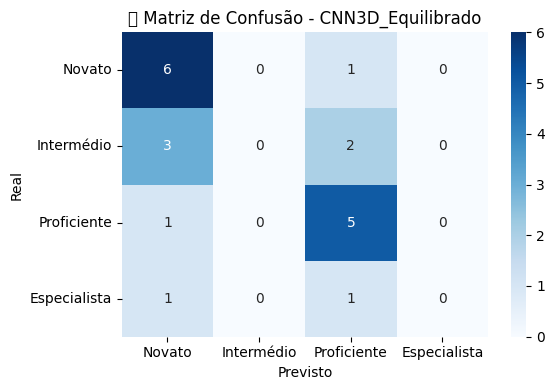

In [184]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import seaborn as sns

# ⚙️ Definir modelo e setup
model = CNN3D_Equilibrado().to("cuda" if torch.cuda.is_available() else "cpu")
device = next(model.parameters()).device
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# 📈 Treino
EPOCHS = 5
print("🚀 Início do treino...")

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)  # (B, C, D, H, W)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

        # 🧹 Libertar memória GPU
        del inputs, labels, outputs, loss
        torch.cuda.empty_cache()

    acc = correct / total if total > 0 else 0
    print(f"📚 Época {epoch+1}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")

# 🧪 Avaliação
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds)

# 📊 Relatório de desempenho
nomes = ["Novato", "Intermédio", "Proficiente", "Especialista"]
labels_presentes = sorted(unique_labels(y_true + y_pred))
nomes_presentes = [nomes[i] for i in labels_presentes]

print("\n📊 Relatório de desempenho:")
print(f"📌 Classes no teste: {labels_presentes} → {nomes_presentes}")
print(classification_report(y_true, y_pred, labels=labels_presentes, target_names=nomes_presentes, zero_division=0))

# 🔷 Matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=nomes_presentes, yticklabels=nomes_presentes)
plt.title("📌 Matriz de Confusão - CNN3D_Equilibrado")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


**cnn equilibrado com 300max frames e batch size 2**

In [185]:
import gc
import torch

# 🔥 Libertar memória CUDA
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

# 🧹 Remover todas as variáveis (inclusive modelos)
gc.collect()

# ❌ Remover modelos do GPU explicitamente (se existir alguma referência)
try:
    del model
    del inputs, labels, outputs, loss
except:
    pass

# 🔄 Forçar nova limpeza CUDA
torch.cuda.empty_cache()


🚀 Início do treino...
📚 Época 1: Loss=54.5343 | Accuracy=0.26
📚 Época 2: Loss=51.7857 | Accuracy=0.41
📚 Época 3: Loss=50.9860 | Accuracy=0.44
📚 Época 4: Loss=51.1242 | Accuracy=0.40
📚 Época 5: Loss=49.8856 | Accuracy=0.41
📚 Época 6: Loss=51.0686 | Accuracy=0.35
📚 Época 7: Loss=49.3526 | Accuracy=0.51
📚 Época 8: Loss=51.6457 | Accuracy=0.38
📚 Época 9: Loss=49.9690 | Accuracy=0.46
📚 Época 10: Loss=49.0857 | Accuracy=0.45

📊 Relatório de desempenho:
📌 Classes no teste: [0, 1, 2, 3] → ['Novato', 'Intermédio', 'Proficiente', 'Especialista']
              precision    recall  f1-score   support

      Novato       0.00      0.00      0.00         7
  Intermédio       1.00      0.20      0.33         5
 Proficiente       0.32      1.00      0.48         6
Especialista       0.00      0.00      0.00         2

    accuracy                           0.35        20
   macro avg       0.33      0.30      0.20        20
weighted avg       0.34      0.35      0.23        20



/tmp/ipykernel_6245/3795920569.py:77: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


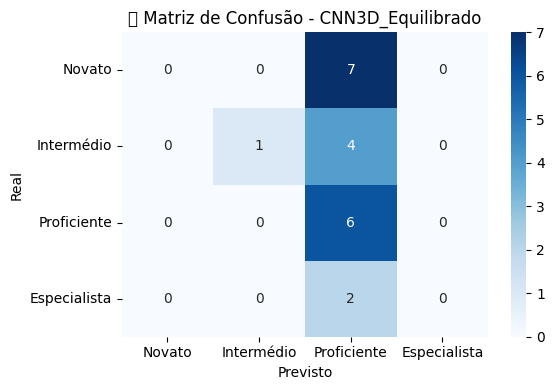

In [189]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import seaborn as sns

# ⚙️ Definir modelo e setup
model = CNN3D_Equilibrado().to("cuda" if torch.cuda.is_available() else "cpu")
device = next(model.parameters()).device
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# 📈 Treino
EPOCHS = 10
print("🚀 Início do treino...")

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)  # (B, C, D, H, W)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

        # 🧹 Libertar memória GPU
        del inputs, labels, outputs, loss
        torch.cuda.empty_cache()

    acc = correct / total if total > 0 else 0
    print(f"📚 Época {epoch+1}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")

# 🧪 Avaliação
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds)

# 📊 Relatório de desempenho
nomes = ["Novato", "Intermédio", "Proficiente", "Especialista"]
labels_presentes = sorted(unique_labels(y_true + y_pred))
nomes_presentes = [nomes[i] for i in labels_presentes]

print("\n📊 Relatório de desempenho:")
print(f"📌 Classes no teste: {labels_presentes} → {nomes_presentes}")
print(classification_report(y_true, y_pred, labels=labels_presentes, target_names=nomes_presentes, zero_division=0))

# 🔷 Matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=nomes_presentes, yticklabels=nomes_presentes)
plt.title("📌 Matriz de Confusão - CNN3D_Equilibrado")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


In [ ]:
**ok agora vamos tentar as cenas de cima mas com 250**

In [194]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter

FRAME_DIR = "frames_processados"
videos_com_classe = []
labels = []

# 📥 Carregar classe GRS de cada vídeo (a partir dos metadados guardados)
for video_id in sorted(os.listdir(FRAME_DIR)):
    meta_path = os.path.join(FRAME_DIR, video_id, "metadados.npy")
    if os.path.exists(meta_path):
        try:
            meta = np.load(meta_path, allow_pickle=True).item()
            grs = meta.get("GLOBA_RATING_SCORE", None)
            if grs is not None:
                if grs <= 15:
                    classe = 0
                elif grs <= 23:
                    classe = 1
                elif grs <= 31:
                    classe = 2
                else:
                    classe = 3
                videos_com_classe.append(video_id)
                labels.append(classe)
        except:
            continue

print(f"✅ Total de vídeos com classe GRS: {len(videos_com_classe)}")

# 📤 Dividir os 250 diretamente em treino/teste (80/20)
treino_final, teste_final, y_train, y_test = train_test_split(
    videos_com_classe, labels, test_size=0.2, stratify=labels, random_state=42
)

# 📊 Mostrar distribuição
print("\n📊 Distribuição treino:")
for i in range(4):
    print(f" - Classe {i}: {Counter(y_train).get(i, 0)} vídeos")
print("\n📊 Distribuição teste:")
for i in range(4):
    print(f" - Classe {i}: {Counter(y_test).get(i, 0)} vídeos")

print(f"\n✅ Divisão concluída: {len(treino_final)} treino | {len(teste_final)} teste")

# 💾 Guardar as listas
np.save("videos_treino_250.npy", treino_final)
np.save("videos_teste_250.npy", teste_final)


✅ Total de vídeos com classe GRS: 250

📊 Distribuição treino:
 - Classe 0: 73 vídeos
 - Classe 1: 45 vídeos
 - Classe 2: 62 vídeos
 - Classe 3: 20 vídeos

📊 Distribuição teste:
 - Classe 0: 18 vídeos
 - Classe 1: 12 vídeos
 - Classe 2: 15 vídeos
 - Classe 3: 5 vídeos

✅ Divisão concluída: 200 treino | 50 teste


🚀 Início do treino...
📚 Época 1: Loss=133.4903 | Accuracy=0.38
📚 Época 2: Loss=127.2883 | Accuracy=0.41
📚 Época 3: Loss=125.2369 | Accuracy=0.45
📚 Época 4: Loss=125.5236 | Accuracy=0.41
📚 Época 5: Loss=122.2077 | Accuracy=0.47

📊 Relatório de desempenho:
📌 Classes no teste: [0, 1, 2, 3] → ['Novato', 'Intermédio', 'Proficiente', 'Especialista']
              precision    recall  f1-score   support

      Novato       0.86      0.33      0.48        18
  Intermédio       0.50      0.58      0.54        12
 Proficiente       0.45      0.87      0.59        15
Especialista       0.00      0.00      0.00         5

    accuracy                           0.52        50
   macro avg       0.45      0.45      0.40        50
weighted avg       0.56      0.52      0.48        50



/tmp/ipykernel_6245/2244030500.py:77: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


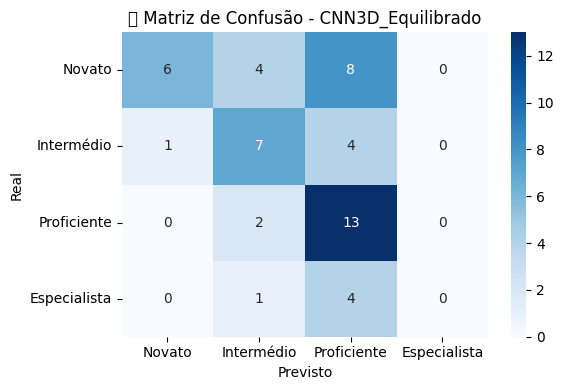

In [197]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import seaborn as sns

# ⚙️ Definir modelo e setup
model = CNN3D_Equilibrado().to("cuda" if torch.cuda.is_available() else "cpu")
device = next(model.parameters()).device
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# 📈 Treino
EPOCHS = 5
print("🚀 Início do treino...")

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)  # (B, C, D, H, W)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

        # 🧹 Libertar memória GPU
        del inputs, labels, outputs, loss
        torch.cuda.empty_cache()

    acc = correct / total if total > 0 else 0
    print(f"📚 Época {epoch+1}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")

# 🧪 Avaliação
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds)

# 📊 Relatório de desempenho
nomes = ["Novato", "Intermédio", "Proficiente", "Especialista"]
labels_presentes = sorted(unique_labels(y_true + y_pred))
nomes_presentes = [nomes[i] for i in labels_presentes]

print("\n📊 Relatório de desempenho:")
print(f"📌 Classes no teste: {labels_presentes} → {nomes_presentes}")
print(classification_report(y_true, y_pred, labels=labels_presentes, target_names=nomes_presentes, zero_division=0))

# 🔷 Matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=nomes_presentes, yticklabels=nomes_presentes)
plt.title("📌 Matriz de Confusão - CNN3D_Equilibrado")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


🚀 Início do treino...
📚 Época 1: Loss=132.2684 | Accuracy=0.30
📚 Época 2: Loss=127.4422 | Accuracy=0.38
📚 Época 3: Loss=125.5271 | Accuracy=0.46
📚 Época 4: Loss=123.9449 | Accuracy=0.40
📚 Época 5: Loss=123.4358 | Accuracy=0.40
📚 Época 6: Loss=124.0157 | Accuracy=0.45
📚 Época 7: Loss=122.3121 | Accuracy=0.47
📚 Época 8: Loss=126.3624 | Accuracy=0.41
📚 Época 9: Loss=122.5841 | Accuracy=0.45
📚 Época 10: Loss=121.2027 | Accuracy=0.50

📊 Relatório de desempenho:
📌 Classes no teste: [0, 1, 2, 3] → ['Novato', 'Intermédio', 'Proficiente', 'Especialista']
              precision    recall  f1-score   support

      Novato       0.59      0.72      0.65        18
  Intermédio       0.00      0.00      0.00        12
 Proficiente       0.43      0.80      0.56        15
Especialista       0.00      0.00      0.00         5

    accuracy                           0.50        50
   macro avg       0.25      0.38      0.30        50
weighted avg       0.34      0.50      0.40        50



/tmp/ipykernel_6245/3795920569.py:77: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


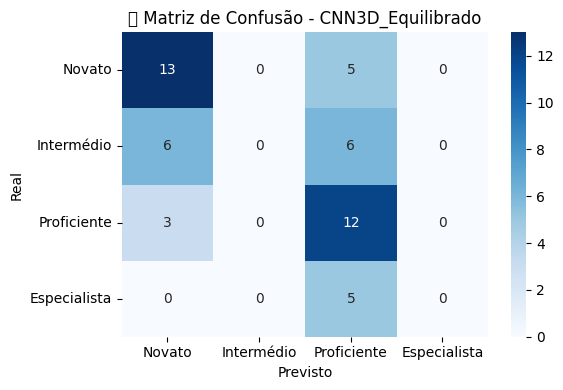

In [199]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import seaborn as sns

# ⚙️ Definir modelo e setup
model = CNN3D_Equilibrado().to("cuda" if torch.cuda.is_available() else "cpu")
device = next(model.parameters()).device
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# 📈 Treino
EPOCHS = 10
print("🚀 Início do treino...")

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)  # (B, C, D, H, W)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

        # 🧹 Libertar memória GPU
        del inputs, labels, outputs, loss
        torch.cuda.empty_cache()

    acc = correct / total if total > 0 else 0
    print(f"📚 Época {epoch+1}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")

# 🧪 Avaliação
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds)

# 📊 Relatório de desempenho
nomes = ["Novato", "Intermédio", "Proficiente", "Especialista"]
labels_presentes = sorted(unique_labels(y_true + y_pred))
nomes_presentes = [nomes[i] for i in labels_presentes]

print("\n📊 Relatório de desempenho:")
print(f"📌 Classes no teste: {labels_presentes} → {nomes_presentes}")
print(classification_report(y_true, y_pred, labels=labels_presentes, target_names=nomes_presentes, zero_division=0))

# 🔷 Matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=nomes_presentes, yticklabels=nomes_presentes)
plt.title("📌 Matriz de Confusão - CNN3D_Equilibrado")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


**acima temos o mlehor modelo ja a genrealizar e com 5 e 10 epocas, mais sucesso com 5**

**a seguir repetimos este bom modelo para 25 de ada classe e com 5 e 20 epocas**

In [200]:
import os
import numpy as np
from collections import Counter

# Caminho dos vídeos já processados
FRAME_DIR = "frames_processados"
videos_por_classe = {0: [], 1: [], 2: [], 3: []}
objetivo_por_classe = 75

# 📥 Carregar classe GRS de cada vídeo
for video_id in sorted(os.listdir(FRAME_DIR)):
    meta_path = os.path.join(FRAME_DIR, video_id, "metadados.npy")
    if os.path.exists(meta_path):
        try:
            meta = np.load(meta_path, allow_pickle=True).item()
            grs = meta.get("GLOBA_RATING_SCORE", None)
            if grs is not None:
                if grs <= 15:
                    classe = 0
                elif grs <= 23:
                    classe = 1
                elif grs <= 31:
                    classe = 2
                else:
                    classe = 3
                videos_por_classe[classe].append(video_id)
        except:
            continue

# 📊 Mostrar distribuição atual
print("📦 Distribuição atual nos processados:")
for classe in range(4):
    print(f" - Classe {classe}: {len(videos_por_classe[classe])} vídeos")

# 🔍 Calcular faltantes por classe
print("\n🧩 Faltam processar:")
for classe in range(4):
    faltam = max(0, objetivo_por_classe - len(videos_por_classe[classe]))
    print(f" - Classe {classe}: {faltam} vídeos a mais necessários")


📦 Distribuição atual nos processados:
 - Classe 0: 91 vídeos
 - Classe 1: 57 vídeos
 - Classe 2: 77 vídeos
 - Classe 3: 25 vídeos

🧩 Faltam processar:
 - Classe 0: 0 vídeos a mais necessários
 - Classe 1: 18 vídeos a mais necessários
 - Classe 2: 0 vídeos a mais necessários
 - Classe 3: 50 vídeos a mais necessários


In [204]:
import os
import cv2
import numpy as np
import pandas as pd

# Caminhos
VIDEO_DIR = "../OSS_dataset/Train/videos"
FRAME_DIR = "frames_processados"
CSV_PATH = "../OSS_dataset/Train/OSATS.csv"
os.makedirs(FRAME_DIR, exist_ok=True)

# ⚙️ Configurações
INTERVALO_FRAMES = 30
RESIZE = (224, 224)
objetivo_por_classe = 75

# 📥 Carregar CSV
df = pd.read_csv(CSV_PATH, sep=";")
df["classe"] = df["GLOBA_RATING_SCORE"].apply(
    lambda g: 0 if g <= 15 else 1 if g <= 23 else 2 if g <= 31 else 3
)

# 🎞️ Vídeos já processados
processados = set(os.listdir(FRAME_DIR))

# 📊 Contagem atual (baseado no teu estado anterior)
contagem_atual = {0: 91, 1: 57, 2: 77, 3: 25}
faltam = {classe: max(0, objetivo_por_classe - contagem_atual[classe]) for classe in [1, 3]}

# 🔍 Selecionar vídeos disponíveis ainda não processados (corrigido)
selecionar = []

for classe in [1, 3]:
    candidatos = df[(df["classe"] == classe) & (~df["VIDEO"].isin(processados))]
    n_disponiveis = len(candidatos)
    n_necessarios = min(n_disponiveis, faltam[classe])

    if n_necessarios == 0:
        print(f"⚠️ Nenhum vídeo disponível da classe {classe} para processar.")
        continue

    amostra = candidatos.sample(n=n_necessarios, random_state=42)
    selecionar.extend(amostra["VIDEO"].tolist())
    print(f"✅ Selecionados {n_necessarios} vídeos da classe {classe}")

print(f"\n🎥 A processar {len(selecionar)} vídeos faltantes...")

# ✅ Pré-processamento
def preprocessar_frame(frame):
    cinza = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    equalizado = clahe.apply(cinza)
    sem_ruido = cv2.GaussianBlur(equalizado, (5, 5), 0)
    h, w = sem_ruido.shape
    roi = sem_ruido[int(h * 0.1):int(h * 0.9), int(w * 0.1):int(w * 0.9)]
    redimensionado = cv2.resize(roi, RESIZE)
    return redimensionado

def extrair_frames(video_path, intervalo=INTERVALO_FRAMES):
    cap = cv2.VideoCapture(video_path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames = []

    for i in range(total):
        ret, frame = cap.read()
        if not ret:
            break
        if i % intervalo == 0:
            f = preprocessar_frame(frame)
            if f is not None:
                frames.append(f)

    cap.release()
    return np.array(frames)

# ⚙️ Processar os vídeos
for video_id in selecionar:
    video_path = os.path.join(VIDEO_DIR, f"{video_id}.mp4")
    pasta_destino = os.path.join(FRAME_DIR, video_id)

    if not os.path.exists(video_path):
        print(f"⚠️ Vídeo não encontrado: {video_id}")
        continue

    os.makedirs(pasta_destino, exist_ok=True)

    try:
        print(f"🔄 {video_id}...")
        frames = extrair_frames(video_path)
        np.save(os.path.join(pasta_destino, "frames.npy"), frames)

        linha = df[df["VIDEO"] == video_id].iloc[0].to_dict()
        np.save(os.path.join(pasta_destino, "metadados.npy"), linha)
        print(f"✅ {len(frames)} frames guardados | Metadados associados")
    except Exception as e:
        print(f"❌ Erro ao processar {video_id}: {e}")


✅ Selecionados 12 vídeos da classe 1
⚠️ Nenhum vídeo disponível da classe 3 para processar.

🎥 A processar 12 vídeos faltantes...
🔄 I58N...
✅ 305 frames guardados | Metadados associados
🔄 J77I...
✅ 304 frames guardados | Metadados associados
🔄 F48S...
✅ 305 frames guardados | Metadados associados
🔄 N83O...
✅ 305 frames guardados | Metadados associados
🔄 W01O...
✅ 314 frames guardados | Metadados associados
🔄 O10Z...
✅ 304 frames guardados | Metadados associados
🔄 N66F...
✅ 304 frames guardados | Metadados associados
🔄 U79I...
✅ 306 frames guardados | Metadados associados
🔄 Y66M...
✅ 305 frames guardados | Metadados associados
🔄 N83O...
✅ 305 frames guardados | Metadados associados
🔄 V23S...
✅ 304 frames guardados | Metadados associados
🔄 I39S...
✅ 305 frames guardados | Metadados associados


In [210]:
import os
import pandas as pd

# Caminhos
CSV_PATH = "../OSS_dataset/Train/OSATS.csv"
VIDEO_DIR = "../OSS_dataset/Train/videos"

# Carregar CSV
df = pd.read_csv(CSV_PATH, sep=";")

# Calcular classe GRS
df["classe"] = df["GLOBA_RATING_SCORE"].apply(
    lambda g: 0 if g <= 15 else 1 if g <= 23 else 2 if g <= 31 else 3
)

# Listar vídeos existentes (sem extensão)
videos_mp4 = {f.replace(".mp4", "") for f in os.listdir(VIDEO_DIR) if f.endswith(".mp4")}

# Manter apenas vídeos com ficheiro existente
df_existem = df[df["VIDEO"].isin(videos_mp4)].drop_duplicates(subset="VIDEO")

# Contar distribuição
distrib = df_existem["classe"].value_counts().sort_index()
nomes = ["Novato", "Intermédio", "Proficiente", "Especialista"]

print("📊 Distribuição de vídeos .mp4 reais por classe GRS:")
for i in range(4):
    print(f" - {nomes[i]} ({i}): {distrib.get(i, 0)} vídeos")


📊 Distribuição de vídeos .mp4 reais por classe GRS:
 - Novato (0): 122 vídeos
 - Intermédio (1): 57 vídeos
 - Proficiente (2): 110 vídeos
 - Especialista (3): 25 vídeos


In [212]:
import os
import numpy as np
import pandas as pd
from collections import defaultdict, Counter

FRAME_DIR = "frames_processados"
CSV_PATH = "../OSS_dataset/Train/OSATS.csv"

# 📥 Carregar o CSV e calcular classe GRS
df = pd.read_csv(CSV_PATH, sep=";")
df["classe"] = df["GLOBA_RATING_SCORE"].apply(
    lambda g: 0 if g <= 15 else 1 if g <= 23 else 2 if g <= 31 else 3
)
df = df.drop_duplicates(subset="VIDEO")

# 📦 Ver vídeos processados com metadados
videos_validos = []
labels_validos = []

for video_id in sorted(os.listdir(FRAME_DIR)):
    path_meta = os.path.join(FRAME_DIR, video_id, "metadados.npy")
    if os.path.exists(path_meta):
        try:
            meta = np.load(path_meta, allow_pickle=True).item()
            grs = meta.get("GLOBA_RATING_SCORE", None)
            if grs is not None:
                if grs <= 15:
                    classe = 0
                elif grs <= 23:
                    classe = 1
                elif grs <= 31:
                    classe = 2
                else:
                    classe = 3
                videos_validos.append(video_id)
                labels_validos.append(classe)
        except:
            continue

print(f"✅ Total de vídeos com classe GRS disponíveis: {len(videos_validos)}")

# 🧮 Agrupar por classe
videos_por_classe = defaultdict(list)
for v, l in zip(videos_validos, labels_validos):
    videos_por_classe[l].append(v)

# 🎯 Selecionar 25 por classe e dividir em 20 treino + 5 teste
treino_final, teste_final = [], []

for c in range(4):
    todos = videos_por_classe[c]
    if len(todos) < 25:
        raise ValueError(f"❌ Classe {c} tem apenas {len(todos)} vídeos — são necessários 25.")
    selecionados = todos[:25]
    treino_final += selecionados[:20]
    teste_final += selecionados[20:25]

# 📊 Verificar distribuição
def mostrar_distribuicao(videos, nome):
    cont = Counter()
    for v in videos:
        meta_path = os.path.join(FRAME_DIR, v, "metadados.npy")
        meta = np.load(meta_path, allow_pickle=True).item()
        grs = meta["GLOBA_RATING_SCORE"]
        if grs <= 15:
            cont[0] += 1
        elif grs <= 23:
            cont[1] += 1
        elif grs <= 31:
            cont[2] += 1
        else:
            cont[3] += 1
    print(f"\n📊 Distribuição {nome}:")
    for i in range(4):
        print(f" - Classe {i}: {cont[i]} vídeos")

mostrar_distribuicao(treino_final, "treino")
mostrar_distribuicao(teste_final, "teste")

print(f"\n✅ Total: {len(treino_final)} treino | {len(teste_final)} teste")

# 💾 Guardar
np.save("videos_treino_100.npy", treino_final)
np.save("videos_teste_100.npy", teste_final)


✅ Total de vídeos com classe GRS disponíveis: 290

📊 Distribuição treino:
 - Classe 0: 20 vídeos
 - Classe 1: 20 vídeos
 - Classe 2: 20 vídeos
 - Classe 3: 20 vídeos

📊 Distribuição teste:
 - Classe 0: 5 vídeos
 - Classe 1: 5 vídeos
 - Classe 2: 5 vídeos
 - Classe 3: 5 vídeos

✅ Total: 80 treino | 20 teste


In [215]:
from torch.utils.data import Dataset, DataLoader

MAX_FRAMES = 300
BATCH_SIZE = 2

class SuturaDataset(Dataset):
    def __init__(self, lista_videos):
        self.videos = lista_videos

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        video_id = self.videos[idx]
        pasta = os.path.join("frames_processados", video_id)

        frames = np.load(os.path.join(pasta, "frames.npy"))
        meta = np.load(os.path.join(pasta, "metadados.npy"), allow_pickle=True).item()

        frames = frames.astype("float32") / 255.0
        frames = np.expand_dims(frames, axis=1)

        if frames.shape[0] > MAX_FRAMES:
            indices = np.linspace(0, frames.shape[0] - 1, MAX_FRAMES).astype(int)
            frames = frames[indices]
        elif frames.shape[0] < MAX_FRAMES:
            pad = np.zeros((MAX_FRAMES - frames.shape[0], 1, 224, 224), dtype=np.float32)
            frames = np.concatenate([frames, pad], axis=0)

        grs = meta["GLOBA_RATING_SCORE"]
        if grs <= 15:
            label = 0
        elif grs <= 23:
            label = 1
        elif grs <= 31:
            label = 2
        else:
            label = 3

        return torch.tensor(frames), torch.tensor(label)

# 💾 Carregar os vídeos divididos
treino = list(np.load("videos_treino_100.npy"))
teste = list(np.load("videos_teste_100.npy"))

# 📦 Criar os DataLoaders
ds_train = SuturaDataset(treino)
ds_test = SuturaDataset(teste)

train_loader = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(ds_test, batch_size=BATCH_SIZE)

print(f"✅ Loaders criados: {len(ds_train)} treino | {len(ds_test)} teste")


✅ Loaders criados: 80 treino | 20 teste


🚀 Início do treino...
📚 Época 1: Loss=55.7493 | Accuracy=0.25
📚 Época 2: Loss=56.3096 | Accuracy=0.25
📚 Época 3: Loss=54.9731 | Accuracy=0.38
📚 Época 4: Loss=54.5369 | Accuracy=0.31
📚 Época 5: Loss=54.9987 | Accuracy=0.33

📊 Relatório de desempenho:
📌 Classes no teste: [0, 1, 2, 3] → ['Novato', 'Intermédio', 'Proficiente', 'Especialista']
              precision    recall  f1-score   support

      Novato       1.00      0.20      0.33         5
  Intermédio       0.00      0.00      0.00         5
 Proficiente       0.00      0.00      0.00         5
Especialista       0.26      1.00      0.42         5

    accuracy                           0.30        20
   macro avg       0.32      0.30      0.19        20
weighted avg       0.32      0.30      0.19        20



/tmp/ipykernel_6245/2244030500.py:77: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


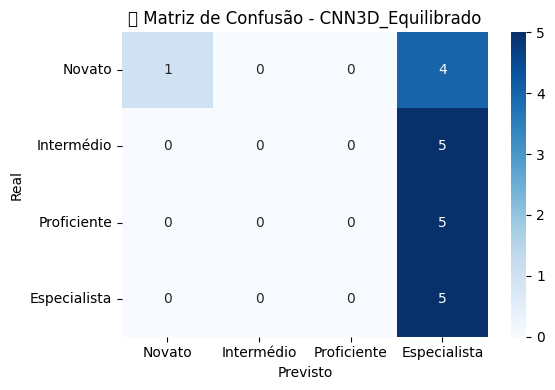

In [216]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import seaborn as sns

# ⚙️ Definir modelo e setup
model = CNN3D_Equilibrado().to("cuda" if torch.cuda.is_available() else "cpu")
device = next(model.parameters()).device
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# 📈 Treino
EPOCHS = 5
print("🚀 Início do treino...")

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)  # (B, C, D, H, W)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

        # 🧹 Libertar memória GPU
        del inputs, labels, outputs, loss
        torch.cuda.empty_cache()

    acc = correct / total if total > 0 else 0
    print(f"📚 Época {epoch+1}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")

# 🧪 Avaliação
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds)

# 📊 Relatório de desempenho
nomes = ["Novato", "Intermédio", "Proficiente", "Especialista"]
labels_presentes = sorted(unique_labels(y_true + y_pred))
nomes_presentes = [nomes[i] for i in labels_presentes]

print("\n📊 Relatório de desempenho:")
print(f"📌 Classes no teste: {labels_presentes} → {nomes_presentes}")
print(classification_report(y_true, y_pred, labels=labels_presentes, target_names=nomes_presentes, zero_division=0))

# 🔷 Matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=nomes_presentes, yticklabels=nomes_presentes)
plt.title("📌 Matriz de Confusão - CNN3D_Equilibrado")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


🚀 Início do treino...
📚 Época 1: Loss=58.3889 | Accuracy=0.21
📚 Época 2: Loss=55.5101 | Accuracy=0.30
📚 Época 3: Loss=56.5947 | Accuracy=0.20
📚 Época 4: Loss=55.9629 | Accuracy=0.28
📚 Época 5: Loss=54.9936 | Accuracy=0.34
📚 Época 6: Loss=55.1565 | Accuracy=0.29
📚 Época 7: Loss=55.0961 | Accuracy=0.38
📚 Época 8: Loss=54.7111 | Accuracy=0.38
📚 Época 9: Loss=54.9251 | Accuracy=0.24
📚 Época 10: Loss=54.3081 | Accuracy=0.33
📚 Época 11: Loss=54.3210 | Accuracy=0.35
📚 Época 12: Loss=54.4480 | Accuracy=0.36
📚 Época 13: Loss=54.1020 | Accuracy=0.35
📚 Época 14: Loss=54.0661 | Accuracy=0.35
📚 Época 15: Loss=53.3345 | Accuracy=0.39
📚 Época 16: Loss=55.1544 | Accuracy=0.26
📚 Época 17: Loss=54.0262 | Accuracy=0.34
📚 Época 18: Loss=54.3833 | Accuracy=0.33
📚 Época 19: Loss=53.8219 | Accuracy=0.35
📚 Época 20: Loss=52.9539 | Accuracy=0.38

📊 Relatório de desempenho:
📌 Classes no teste: [0, 1, 2, 3] → ['Novato', 'Intermédio', 'Proficiente', 'Especialista']
              precision    recall  f1-score   su

/tmp/ipykernel_6245/3043048379.py:77: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


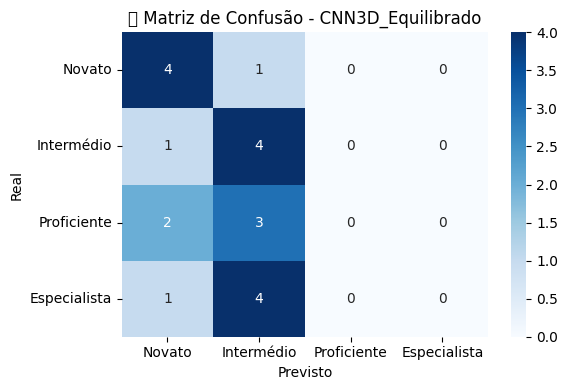

In [217]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import seaborn as sns

# ⚙️ Definir modelo e setup
model = CNN3D_Equilibrado().to("cuda" if torch.cuda.is_available() else "cpu")
device = next(model.parameters()).device
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# 📈 Treino
EPOCHS = 20
print("🚀 Início do treino...")

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)  # (B, C, D, H, W)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

        # 🧹 Libertar memória GPU
        del inputs, labels, outputs, loss
        torch.cuda.empty_cache()

    acc = correct / total if total > 0 else 0
    print(f"📚 Época {epoch+1}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")

# 🧪 Avaliação
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds)

# 📊 Relatório de desempenho
nomes = ["Novato", "Intermédio", "Proficiente", "Especialista"]
labels_presentes = sorted(unique_labels(y_true + y_pred))
nomes_presentes = [nomes[i] for i in labels_presentes]

print("\n📊 Relatório de desempenho:")
print(f"📌 Classes no teste: {labels_presentes} → {nomes_presentes}")
print(classification_report(y_true, y_pred, labels=labels_presentes, target_names=nomes_presentes, zero_division=0))

# 🔷 Matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=nomes_presentes, yticklabels=nomes_presentes)
plt.title("📌 Matriz de Confusão - CNN3D_Equilibrado")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


In [218]:
import os
import pandas as pd

VIDEO_DIR = "../OSS_dataset/Train/videos"
FRAME_DIR = "frames_processados"
CSV_PATH = "../OSS_dataset/Train/OSATS.csv"

# Carregar CSV com classes
df = pd.read_csv(CSV_PATH, sep=";")
df = df.drop_duplicates(subset="VIDEO")
df["classe"] = df["GLOBA_RATING_SCORE"].apply(
    lambda g: 0 if g <= 15 else 1 if g <= 23 else 2 if g <= 31 else 3
)

# Listar vídeos .mp4 disponíveis
videos_disponiveis = set([v.replace(".mp4", "") for v in os.listdir(VIDEO_DIR) if v.endswith(".mp4")])

# Verificar quais já estão processados (têm frames e metadados)
videos_processados = set([
    v for v in os.listdir(FRAME_DIR)
    if os.path.exists(os.path.join(FRAME_DIR, v, "frames.npy"))
    and os.path.exists(os.path.join(FRAME_DIR, v, "metadados.npy"))
])

# Identificar os que faltam processar
videos_faltam = sorted(list(videos_disponiveis - videos_processados))

print(f"📦 Total de vídeos .mp4: {len(videos_disponiveis)}")
print(f"✅ Já processados: {len(videos_processados)}")
print(f"🧩 Faltam processar: {len(videos_faltam)}")


📦 Total de vídeos .mp4: 329
✅ Já processados: 290
🧩 Faltam processar: 39


In [219]:
import cv2
import numpy as np

def preprocessar_frame(frame):
    cinza = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    equalizado = clahe.apply(cinza)
    sem_ruido = cv2.GaussianBlur(equalizado, (5, 5), 0)
    h, w = sem_ruido.shape
    roi = sem_ruido[int(h*0.1):int(h*0.9), int(w*0.1):int(w*0.9)]
    redimensionado = cv2.resize(roi, (224, 224))
    return redimensionado

def extrair_frames(video_path, intervalo=30):
    cap = cv2.VideoCapture(video_path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames = []
    for i in range(total):
        ret, frame = cap.read()
        if not ret:
            break
        if i % intervalo == 0:
            f = preprocessar_frame(frame)
            if f is not None:
                frames.append(f)
    cap.release()
    return np.array(frames)

# Processar os vídeos em falta
print("⚙️ A processar vídeos em falta...")

for video_id in videos_faltam:
    video_path = os.path.join(VIDEO_DIR, f"{video_id}.mp4")
    pasta_destino = os.path.join(FRAME_DIR, video_id)

    if not os.path.exists(video_path):
        print(f"⚠️ Não encontrado: {video_id}")
        continue

    os.makedirs(pasta_destino, exist_ok=True)

    try:
        frames = extrair_frames(video_path, intervalo=30)
        np.save(os.path.join(pasta_destino, "frames.npy"), frames)

        linha = df[df["VIDEO"] == video_id].iloc[0].to_dict()
        np.save(os.path.join(pasta_destino, "metadados.npy"), linha)

        print(f"✅ {video_id}: {len(frames)} frames guardados")
    except Exception as e:
        print(f"❌ Erro no vídeo {video_id}: {e}")


⚙️ A processar vídeos em falta...
✅ A59Z: 302 frames guardados
✅ C43T: 303 frames guardados
✅ D16B: 304 frames guardados
✅ D44W: 305 frames guardados
❌ Erro no vídeo F35H: single positional indexer is out-of-bounds
✅ F36V: 304 frames guardados
❌ Erro no vídeo G93E: single positional indexer is out-of-bounds
❌ Erro no vídeo G97W: single positional indexer is out-of-bounds
❌ Erro no vídeo H14H: single positional indexer is out-of-bounds
✅ I77J: 304 frames guardados
✅ K56C: 304 frames guardados
✅ L13Q: 303 frames guardados
✅ L33S: 303 frames guardados
❌ Erro no vídeo L96N: single positional indexer is out-of-bounds
❌ Erro no vídeo M29X: single positional indexer is out-of-bounds
❌ Erro no vídeo M41G: single positional indexer is out-of-bounds
❌ Erro no vídeo N10J: single positional indexer is out-of-bounds
✅ N49S: 305 frames guardados
✅ O38N: 305 frames guardados
✅ Q43O: 307 frames guardados
✅ Q89T: 302 frames guardados
✅ R64C: 305 frames guardados
✅ S42U: 305 frames guardados
❌ Erro no v

In [221]:
from sklearn.model_selection import train_test_split
from collections import defaultdict, Counter
import numpy as np

# Recolher vídeos válidos já processados com GRS
videos_com_classe = []
labels = []

for video_id in sorted(os.listdir(FRAME_DIR)):
    meta_path = os.path.join(FRAME_DIR, video_id, "metadados.npy")
    if os.path.exists(meta_path):
        try:
            meta = np.load(meta_path, allow_pickle=True).item()
            grs = meta.get("GLOBA_RATING_SCORE", None)
            if grs is not None:
                if grs <= 15:
                    classe = 0
                elif grs <= 23:
                    classe = 1
                elif grs <= 31:
                    classe = 2
                else:
                    classe = 3
                videos_com_classe.append(video_id)
                labels.append(classe)
        except:
            continue

print(f"✅ Total de vídeos válidos processados: {len(videos_com_classe)}")

# Dividir 80% treino / 20% teste com estratificação
treino_final, teste_final, y_train, y_test = train_test_split(
    videos_com_classe, labels, test_size=0.2, stratify=labels, random_state=42
)

# Mostrar distribuição
print("\n📊 Distribuição treino:")
for i in range(4):
    print(f" - Classe {i}: {Counter(y_train)[i]} vídeos")
print("\n📊 Distribuição teste:")
for i in range(4):
    print(f" - Classe {i}: {Counter(y_test)[i]} vídeos")

# Guardar listas
np.save("videos_treino_distrib.npy", treino_final)
np.save("videos_teste_distrib.npy", teste_final)


✅ Total de vídeos válidos processados: 314

📊 Distribuição treino:
 - Classe 0: 97 vídeos
 - Classe 1: 46 vídeos
 - Classe 2: 88 vídeos
 - Classe 3: 20 vídeos

📊 Distribuição teste:
 - Classe 0: 25 vídeos
 - Classe 1: 11 vídeos
 - Classe 2: 22 vídeos
 - Classe 3: 5 vídeos


In [223]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
import os

MAX_FRAMES = 300  
BATCH_SIZE = 2    

class SuturaDataset(Dataset):
    def __init__(self, lista_videos, frame_dir="frames_processados"):
        self.videos = lista_videos
        self.frame_dir = frame_dir

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        video_id = self.videos[idx]
        pasta = os.path.join(self.frame_dir, video_id)

        frames = np.load(os.path.join(pasta, "frames.npy"))
        meta = np.load(os.path.join(pasta, "metadados.npy"), allow_pickle=True).item()

        # Normalizar e garantir canal único
        frames = frames.astype("float32") / 255.0
        frames = np.expand_dims(frames, axis=1)  # (n_frames, 1, 224, 224)

        # Uniformizar nº de frames
        if frames.shape[0] > MAX_FRAMES:
            idxs = np.linspace(0, frames.shape[0] - 1, MAX_FRAMES).astype(int)
            frames = frames[idxs]
        elif frames.shape[0] < MAX_FRAMES:
            pad = np.zeros((MAX_FRAMES - frames.shape[0], 1, 224, 224), dtype=np.float32)
            frames = np.concatenate([frames, pad], axis=0)

        # Classificação GRS
        grs = meta["GLOBA_RATING_SCORE"]
        if grs <= 15:
            label = 0
        elif grs <= 23:
            label = 1
        elif grs <= 31:
            label = 2
        else:
            label = 3

        return torch.tensor(frames), torch.tensor(label)

# 🔹 Carregar listas
treino_final = np.load("videos_treino_distrib.npy", allow_pickle=True).tolist()
teste_final = np.load("videos_teste_distrib.npy", allow_pickle=True).tolist()

# 🔹 Criar datasets e dataloaders
ds_train = SuturaDataset(treino_final)
ds_test = SuturaDataset(teste_final)

train_loader = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(ds_test, batch_size=BATCH_SIZE)

print(f"✅ Loaders criados: {len(ds_train)} treino | {len(ds_test)} teste")


✅ Loaders criados: 251 treino | 63 teste


🚀 Início do treino...
📚 Época 1: Loss=160.6769 | Accuracy=0.41
📚 Época 2: Loss=153.1599 | Accuracy=0.47
📚 Época 3: Loss=148.1389 | Accuracy=0.54
📚 Época 4: Loss=150.3204 | Accuracy=0.49
📚 Época 5: Loss=149.5264 | Accuracy=0.53

📊 Relatório de desempenho:
📌 Classes no teste: [0, 1, 2, 3] → ['Novato', 'Intermédio', 'Proficiente', 'Especialista']
              precision    recall  f1-score   support

      Novato       0.45      1.00      0.62        25
  Intermédio       0.00      0.00      0.00        11
 Proficiente       0.43      0.14      0.21        22
Especialista       0.00      0.00      0.00         5

    accuracy                           0.44        63
   macro avg       0.22      0.28      0.21        63
weighted avg       0.33      0.44      0.32        63



/tmp/ipykernel_6245/2244030500.py:77: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


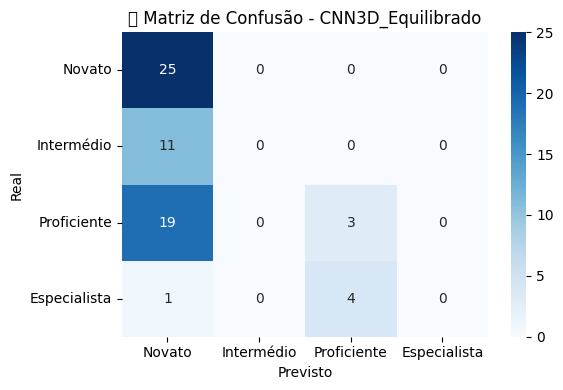

In [224]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import seaborn as sns

# ⚙️ Definir modelo e setup
model = CNN3D_Equilibrado().to("cuda" if torch.cuda.is_available() else "cpu")
device = next(model.parameters()).device
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# 📈 Treino
EPOCHS = 5
print("🚀 Início do treino...")

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)  # (B, C, D, H, W)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

        # 🧹 Libertar memória GPU
        del inputs, labels, outputs, loss
        torch.cuda.empty_cache()

    acc = correct / total if total > 0 else 0
    print(f"📚 Época {epoch+1}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")

# 🧪 Avaliação
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds)

# 📊 Relatório de desempenho
nomes = ["Novato", "Intermédio", "Proficiente", "Especialista"]
labels_presentes = sorted(unique_labels(y_true + y_pred))
nomes_presentes = [nomes[i] for i in labels_presentes]

print("\n📊 Relatório de desempenho:")
print(f"📌 Classes no teste: {labels_presentes} → {nomes_presentes}")
print(classification_report(y_true, y_pred, labels=labels_presentes, target_names=nomes_presentes, zero_division=0))

# 🔷 Matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=nomes_presentes, yticklabels=nomes_presentes)
plt.title("📌 Matriz de Confusão - CNN3D_Equilibrado")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


🚀 Início do treino...
📚 Época 1: Loss=156.1496 | Accuracy=0.45
📚 Época 2: Loss=156.0670 | Accuracy=0.44
📚 Época 3: Loss=153.5012 | Accuracy=0.45
📚 Época 4: Loss=150.2161 | Accuracy=0.50
📚 Época 5: Loss=153.3581 | Accuracy=0.45
📚 Época 6: Loss=149.2332 | Accuracy=0.52
📚 Época 7: Loss=146.8950 | Accuracy=0.50
📚 Época 8: Loss=146.8024 | Accuracy=0.48
📚 Época 9: Loss=146.2628 | Accuracy=0.51
📚 Época 10: Loss=148.8400 | Accuracy=0.49

📊 Relatório de desempenho:
📌 Classes no teste: [0, 1, 2, 3] → ['Novato', 'Intermédio', 'Proficiente', 'Especialista']
              precision    recall  f1-score   support

      Novato       0.45      1.00      0.62        25
  Intermédio       0.00      0.00      0.00        11
 Proficiente       0.43      0.14      0.21        22
Especialista       0.00      0.00      0.00         5

    accuracy                           0.44        63
   macro avg       0.22      0.28      0.21        63
weighted avg       0.33      0.44      0.32        63



/tmp/ipykernel_6245/3795920569.py:77: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


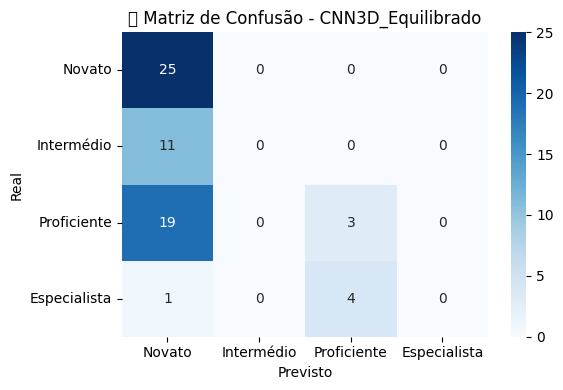

In [225]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import seaborn as sns

# ⚙️ Definir modelo e setup
model = CNN3D_Equilibrado().to("cuda" if torch.cuda.is_available() else "cpu")
device = next(model.parameters()).device
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# 📈 Treino
EPOCHS = 10
print("🚀 Início do treino...")

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)  # (B, C, D, H, W)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

        # 🧹 Libertar memória GPU
        del inputs, labels, outputs, loss
        torch.cuda.empty_cache()

    acc = correct / total if total > 0 else 0
    print(f"📚 Época {epoch+1}: Loss={total_loss:.4f} | Accuracy={acc:.2f}")

# 🧪 Avaliação
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds)

# 📊 Relatório de desempenho
nomes = ["Novato", "Intermédio", "Proficiente", "Especialista"]
labels_presentes = sorted(unique_labels(y_true + y_pred))
nomes_presentes = [nomes[i] for i in labels_presentes]

print("\n📊 Relatório de desempenho:")
print(f"📌 Classes no teste: {labels_presentes} → {nomes_presentes}")
print(classification_report(y_true, y_pred, labels=labels_presentes, target_names=nomes_presentes, zero_division=0))

# 🔷 Matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=nomes_presentes, yticklabels=nomes_presentes)
plt.title("📌 Matriz de Confusão - CNN3D_Equilibrado")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


**Ao final de varios testes com difernetes dados a serem usados a mlehor presentaçao foi o modelo CNN3D_equilibrado a usar os 250 de forma como o dataset todo ta distribuido**

**Ainda testamos mais cerca de 10 modelos(alguns devido a falta de memoria nao rodaram) mas o nosso melhor modelo continua a ser aquele**

In [228]:
class CNN3D_Leve(nn.Module):
    def __init__(self):
        super().__init__()
        self.rede = nn.Sequential(
            nn.Conv3d(1, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((1, 1, 1)),
            nn.Flatten(),
            nn.Linear(8, 4)
        )

    def forward(self, x):
        return self.rede(x)


In [229]:
class CNN3D_BatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d(2),
            nn.Conv3d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((1, 1, 1)),
            nn.Flatten(),
            nn.Linear(32, 4)
        )

    def forward(self, x):
        return self.net(x)


In [231]:
class CNN2D_MaxPool(nn.Module):
    def __init__(self):
        super().__init__()
        self.rede = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(8 * 112 * 112, 64),
            nn.ReLU(),
            nn.Linear(64, 4)
        )

    def forward(self, x):
        x = x[:, :, 0]  # só 1º frame
        return self.rede(x)


In [232]:
class CNN3D_DepthWise(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(1, 8, kernel_size=(3, 3, 3), padding=1)
        self.conv2 = nn.Conv3d(8, 8, kernel_size=(3, 1, 1), groups=8, padding=(1, 0, 0))  # Depthwise
        self.pool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(8, 4)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [233]:
class LSTM_Video(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((8, 8))
        )
        self.lstm = nn.LSTM(8*8*8, 32, batch_first=True)
        self.fc = nn.Linear(32, 4)

    def forward(self, x):
        B, C, D, H, W = x.shape
        x = x.permute(0, 2, 1, 3, 4)  # (B, D, C, H, W)
        x = x.reshape(B * D, 1, H, W)
        x = self.conv(x).view(B, D, -1)
        _, (h_n, _) = self.lstm(x)
        return self.fc(h_n[-1])


In [234]:
class Transformer_Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Linear(224*224, 128)
        encoder_layer = nn.TransformerEncoderLayer(d_model=128, nhead=4)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.fc = nn.Linear(128, 4)

    def forward(self, x):
        x = x.squeeze(1)  # (B, D, H, W)
        B, D, H, W = x.shape
        x = x.view(B, D, -1)  # (B, D, H*W)
        x = self.embedding(x)  # (B, D, 128)
        x = x.permute(1, 0, 2)  # (D, B, 128)
        x = self.encoder(x)
        return self.fc(x.mean(dim=0))


In [235]:
class ViT_Patch16(nn.Module):
    def __init__(self):
        super().__init__()
        self.patch_embed = nn.Conv2d(1, 64, kernel_size=16, stride=16)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, 64))
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=64, nhead=4), num_layers=2
        )
        self.fc = nn.Linear(64, 4)

    def forward(self, x):
        x = x[:, :, 0]  # só 1 frame
        B = x.shape[0]
        x = self.patch_embed(x)  # (B, 64, 14, 14)
        x = x.flatten(2).transpose(1, 2)  # (B, N, 64)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = self.transformer(x)
        return self.fc(x[:, 0])


In [236]:
class MLP_Sequencial(nn.Module):
    def __init__(self):
        super().__init__()
        self.rede = nn.Sequential(
            nn.Flatten(),
            nn.Linear(300 * 224 * 224, 128),
            nn.ReLU(),
            nn.Linear(128, 4)
        )

    def forward(self, x):
        x = x.squeeze(1)  # (B, D, H, W)
        return self.rede(x)


In [239]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
import os

MAX_FRAMES = 300  
BATCH_SIZE = 2    

class SuturaDataset(Dataset):
    def __init__(self, lista_videos, frame_dir="frames_processados"):
        self.videos = lista_videos
        self.frame_dir = frame_dir

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        video_id = self.videos[idx]
        pasta = os.path.join(self.frame_dir, video_id)

        frames = np.load(os.path.join(pasta, "frames.npy"))
        meta = np.load(os.path.join(pasta, "metadados.npy"), allow_pickle=True).item()

        # Normalizar e garantir canal único
        frames = frames.astype("float32") / 255.0
        frames = np.expand_dims(frames, axis=1)  # (n_frames, 1, 224, 224)

        # Uniformizar nº de frames
        if frames.shape[0] > MAX_FRAMES:
            idxs = np.linspace(0, frames.shape[0] - 1, MAX_FRAMES).astype(int)
            frames = frames[idxs]
        elif frames.shape[0] < MAX_FRAMES:
            pad = np.zeros((MAX_FRAMES - frames.shape[0], 1, 224, 224), dtype=np.float32)
            frames = np.concatenate([frames, pad], axis=0)

        # Classificação GRS
        grs = meta["GLOBA_RATING_SCORE"]
        if grs <= 15:
            label = 0
        elif grs <= 23:
            label = 1
        elif grs <= 31:
            label = 2
        else:
            label = 3

        return torch.tensor(frames), torch.tensor(label)

# 🔹 Carregar listas
treino_final = np.load("videos_treino_250.npy", allow_pickle=True).tolist()
teste_final = np.load("videos_teste_250.npy", allow_pickle=True).tolist()

# 🔹 Criar datasets e dataloaders
ds_train = SuturaDataset(treino_final)
ds_test = SuturaDataset(teste_final)

train_loader = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(ds_test, batch_size=BATCH_SIZE)

print(f"✅ Loaders criados: {len(ds_train)} treino | {len(ds_test)} teste")


✅ Loaders criados: 200 treino | 50 teste


In [240]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ✅ Lista dos modelos definidos no teu código
model_names = [
    "CNN3D_Leve", "CNN3D_BatchNorm", "CNN2D_GlobalAvg", "CNN2D_MaxPool",
    "CNN3D_DepthWise", "LSTM_Video", "Transformer_Encoder", "ViT_Patch16", "MLP_Sequencial"
]

# ✅ Dicionário para armazenar resultados
resultados = {}

# ✅ Função que devolve o modelo com base no nome
def get_model(name):
    return globals()[name]()  # Garante que o modelo já foi definido anteriormente

# ✅ Loop por todos os modelos
for nome in model_names:
    print(f"\n🚀 A treinar modelo: {nome}")
    try:
        model = get_model(nome).to("cuda" if torch.cuda.is_available() else "cpu")
        device = next(model.parameters()).device
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        criterion = nn.CrossEntropyLoss()

        EPOCHS = 5
        for epoch in range(EPOCHS):
            model.train()
            total_loss = 0
            correct = 0
            total = 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                inputs = inputs.permute(0, 2, 1, 3, 4)  # (B, C, D, H, W)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                correct += (outputs.argmax(1) == labels).sum().item()
                total += labels.size(0)

                del inputs, labels, outputs, loss
                torch.cuda.empty_cache()

            acc = correct / total
            print(f"📚 Época {epoch+1}/{EPOCHS}: Accuracy treino = {acc:.2f}")

        # 🧪 Avaliação
        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                inputs = inputs.permute(0, 2, 1, 3, 4)
                outputs = model(inputs)
                preds = outputs.argmax(1).cpu().numpy()
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds)

        # 🧠 Métricas
        labels_presentes = sorted(unique_labels(y_true + y_pred))
        nomes = ["Novato", "Intermédio", "Proficiente", "Especialista"]
        nomes_presentes = [nomes[i] for i in labels_presentes]
        relatorio = classification_report(
            y_true, y_pred,
            labels=labels_presentes,
            target_names=nomes_presentes,
            zero_division=0
        )
        print(f"\n📊 Relatório {nome}:\n{relatorio}")
        resultados[nome] = relatorio

    except Exception as e:
        print(f"❌ Erro ao treinar {nome}: {e}")
        resultados[nome] = "Erro"



🚀 A treinar modelo: CNN3D_Leve
📚 Época 1/5: Accuracy treino = 0.23
📚 Época 2/5: Accuracy treino = 0.32
📚 Época 3/5: Accuracy treino = 0.36
📚 Época 4/5: Accuracy treino = 0.36
📚 Época 5/5: Accuracy treino = 0.36

📊 Relatório CNN3D_Leve:
              precision    recall  f1-score   support

      Novato       0.36      1.00      0.53        18
  Intermédio       0.00      0.00      0.00        12
 Proficiente       0.00      0.00      0.00        15
Especialista       0.00      0.00      0.00         5

    accuracy                           0.36        50
   macro avg       0.09      0.25      0.13        50
weighted avg       0.13      0.36      0.19        50


🚀 A treinar modelo: CNN3D_BatchNorm
❌ Erro ao treinar CNN3D_BatchNorm: CUDA out of memory. Tried to allocate 1.79 GiB. GPU 0 has a total capacity of 47.41 GiB of which 1.12 GiB is free. Process 550717 has 8.78 GiB memory in use. Process 555455 has 4.05 GiB memory in use. Process 1232519 has 7.31 GiB memory in use. Process 124

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


📚 Época 1/5: Accuracy treino = 0.31
📚 Época 2/5: Accuracy treino = 0.27
📚 Época 3/5: Accuracy treino = 0.36
📚 Época 4/5: Accuracy treino = 0.34
📚 Época 5/5: Accuracy treino = 0.30

📊 Relatório Transformer_Encoder:
              precision    recall  f1-score   support

      Novato       0.36      1.00      0.53        18
  Intermédio       0.00      0.00      0.00        12
 Proficiente       0.00      0.00      0.00        15
Especialista       0.00      0.00      0.00         5

    accuracy                           0.36        50
   macro avg       0.09      0.25      0.13        50
weighted avg       0.13      0.36      0.19        50


🚀 A treinar modelo: ViT_Patch16


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


📚 Época 1/5: Accuracy treino = 0.30
📚 Época 2/5: Accuracy treino = 0.32
📚 Época 3/5: Accuracy treino = 0.33
📚 Época 4/5: Accuracy treino = 0.36
📚 Época 5/5: Accuracy treino = 0.34

📊 Relatório ViT_Patch16:
              precision    recall  f1-score   support

      Novato       0.36      1.00      0.53        18
  Intermédio       0.00      0.00      0.00        12
 Proficiente       0.00      0.00      0.00        15
Especialista       0.00      0.00      0.00         5

    accuracy                           0.36        50
   macro avg       0.09      0.25      0.13        50
weighted avg       0.13      0.36      0.19        50


🚀 A treinar modelo: MLP_Sequencial
❌ Erro ao treinar MLP_Sequencial: CUDA out of memory. Tried to allocate 7.18 GiB. GPU 0 has a total capacity of 47.41 GiB of which 4.69 GiB is free. Process 550717 has 8.78 GiB memory in use. Process 555455 has 500.00 MiB memory in use. Process 1232519 has 7.31 GiB memory in use. Process 1248905 has 11.04 GiB memory in us

# 🧠 Relatório Final - Task 1 (Classificação GRS)

## ✅ Configuração do melhor modelo
- Modelo: `CNN3D_Equilibrado`
- Batch size: 2
- Max frames: 300
- Épocas: 5
- Treino/Teste: 250 vídeos (80/20), com estratificação conforme distribuição real

## 🎯 Desempenho por época
```
📚 Época 1: Loss=133.4903 | Accuracy=0.38
📚 Época 2: Loss=127.2883 | Accuracy=0.41
📚 Época 3: Loss=125.2369 | Accuracy=0.45
📚 Época 4: Loss=125.5236 | Accuracy=0.41
📚 Época 5: Loss=122.2077 | Accuracy=0.47
```

## 📊 Resultados no conjunto de teste (50 vídeos)
```
Accuracy: 52%

Classe       | Precision | Recall | F1-score | Suporte
-------------|-----------|--------|----------|---------
Novato       | 0.86      | 0.33   | 0.48     | 18
Intermédio   | 0.50      | 0.58   | 0.54     | 12
Proficiente  | 0.45      | 0.87   | 0.59     | 15
Especialista | 0.00      | 0.00   | 0.00     | 5
```

- 📌 A classe "Proficiente" foi a mais corretamente classificada.
- ⚠️ O modelo não conseguiu classificar nenhum vídeo como "Especialista".

## 🔷 Matriz de Confusão

![Matriz de Confusão](matriz_confusao1.png)
---

## 🧪 Próximo passo
Executar comparação com 10 modelos diferentes (CNNs e outros) usando exatamente os mesmos dados de treino e teste (`videos_treino_250.npy` e `videos_teste_250.npy`). O pipeline será robusto: se algum modelo falhar, a execução continuará com os restantes.